# 1. Import Packages and Datasets

In [1]:

import numpy as np
import pandas as pd
import os
import gc
import warnings

#Machine Learning

import statsmodels.api as sm
import sklearn

#Data Visualization

#import altair as alt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
#Import datasets
train = pd.read_csv("D:/Bootcamp/Project-Sales/Project_11/Data_set/train.csv",parse_dates=['date'])
test = pd.read_csv("D:/Bootcamp/Project-Sales/Project_11/Data_set/test.csv",parse_dates=['date'])
stores = pd.read_csv("D:/Bootcamp/Project-Sales/Project_11/Data_set/stores.csv")

We will check the data types for each column in the following data sets. In order to perform time series forecasting using the packages we have imported, we must ensure that the dates have been parsed as dates. Later on we will convert the "object" data types to categories. We will also have a look at our datasets to see if we need to do any cleaning or manipulation.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [5]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

# 2. Data Processing

From train.csv and transactions.csv:

* date - The date when the data was recorded.
* store_nbr - Identifies the store at which the products are sold.
* family - Identifies the type of product sold.
* sales - Gives the total sales for a product family at a particular store at a given date. Fractional values are possible.
* onpromotion - Gives the total number of items in a product family that were being promoted at a store at a given date.
* transactions - The total number of transactions that occurred in a store on a given date.

## Remove Sales for Stores who do not Sell a Particular Family of Products
After a quick look at our training dataset, we can see that there are a lot of zeroes. It is possible that some stores do not sell certain products as they are not the right store for that product. In that case, we will remove those values as when forecasted, they should not be having any sales.

In [6]:
zeros = train.groupby(['id', 'store_nbr', 'family']).sales.sum().reset_index().sort_values(['family','store_nbr'])
zeros = zeros[zeros.sales == 0]
zeros

id  store_nbr      family  sales
0              0          1  AUTOMOTIVE    0.0
10692      10692          1  AUTOMOTIVE    0.0
30294      30294          1  AUTOMOTIVE    0.0
40986      40986          1  AUTOMOTIVE    0.0
53460      53460          1  AUTOMOTIVE    0.0
...          ...        ...         ...    ...
2981153  2981153         54     SEAFOOD    0.0
2984717  2984717         54     SEAFOOD    0.0
2986499  2986499         54     SEAFOOD    0.0
2993627  2993627         54     SEAFOOD    0.0
2998973  2998973         54     SEAFOOD    0.0

[939130 rows x 4 columns]

In [7]:
#full outer joining the tables and removing the rows where they match to get rid of the zeros
join = train.merge(zeros[zeros.sales == 0].drop("sales",axis = 1), how='outer', indicator=True)
train1 = join[~(join._merge == 'both')].drop(['id', '_merge'], axis = 1).reset_index()
train1 = train1.drop(['index', 'onpromotion'], axis=1)
train1

date  store_nbr                      family     sales
0       2013-01-01         25                      BEAUTY     2.000
1       2013-01-01         25                   BEVERAGES   810.000
2       2013-01-01         25                BREAD/BAKERY   180.589
3       2013-01-01         25                    CLEANING   186.000
4       2013-01-01         25                       DAIRY   143.000
...            ...        ...                         ...       ...
2061753 2017-08-15          9                     POULTRY   438.133
2061754 2017-08-15          9              PREPARED FOODS   154.553
2061755 2017-08-15          9                     PRODUCE  2419.729
2061756 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000
2061757 2017-08-15          9                     SEAFOOD    16.000

[2061758 rows x 4 columns]

## Cluster Stores
The training data set is what we will use to create our models. There are 54 stores, each with 33 product families. As this is a large dataset with over three million rows, grouping the stores into clusters will greatly reduce the computation of our following models. Fortunately, the stores are already clustered for us in the 'stores' dataset into seventeen clusters. We have also chosen to ignore the 'on promotion' variable for simplicity and time restraints.

In [8]:
def group_clusters (df) :
    #left join train and stores on store number
    jointr = df.merge(stores, on='store_nbr', how='left', indicator=False)

    #replacing all store numbers with their cluster and grouping them by cluster
    grouped = jointr.groupby(['date', 'cluster', 'family']).sum('sales').reset_index()

    #removing columns id, store_nbr, and type as they are aggregated values with no significance
    grouped = grouped.drop(['store_nbr'], axis=1)

    return grouped

In [9]:
grouped = group_clusters (train1)
grouped

date  cluster                   family     sales
0      2013-01-01        1                   BEAUTY     2.000
1      2013-01-01        1                BEVERAGES   810.000
2      2013-01-01        1             BREAD/BAKERY   180.589
3      2013-01-01        1                 CLEANING   186.000
4      2013-01-01        1                    DAIRY   143.000
...           ...      ...                      ...       ...
742573 2017-08-15       17  PLAYERS AND ELECTRONICS    25.000
742574 2017-08-15       17                  POULTRY   686.941
742575 2017-08-15       17           PREPARED FOODS    91.976
742576 2017-08-15       17                  PRODUCE  5031.190
742577 2017-08-15       17                  SEAFOOD    52.876

[742578 rows x 4 columns]

## Grouping Product Families
We will next explore the families to help us better understand which families contribute the most to the total sales of the stores, so that we can potentially group them.

In [10]:
#group by 'family', then sort by sales, and create a column for aggregate sales percent
temp = grouped.groupby('family').sum('sales').reset_index().sort_values(by='sales', ascending=False)

#aggregated sales
temp = temp[['family','sales']]
temp['percent']=(temp['sales']/temp['sales'].sum())
temp['percent'] = temp['percent'].apply(lambda x: f'{x:.0%}')
temp['cumulative']=(temp['sales']/temp['sales'].sum()).cumsum()
temp['cumulative'] = temp['cumulative'].apply(lambda x: f'{x:.0%}')
temp.head()

family         sales percent cumulative
12  GROCERY I  3.434627e+08     32%        32%
3   BEVERAGES  2.169545e+08     20%        52%
30    PRODUCE  1.227047e+08     11%        64%
7    CLEANING  9.752129e+07      9%        73%
8       DAIRY  6.448771e+07      6%        79%

The table above shows the families with the top five contributions to sales over all stores and dates: GROCERY I, BEVERAGES, PRODUCE, CLEANING, and DAIRY. GROCERY I contributes the most to the total sales at 32%. The top five product families account for 79% of total sales. The graph below shows a better picture of the cumulative percentage of sales for the product families.

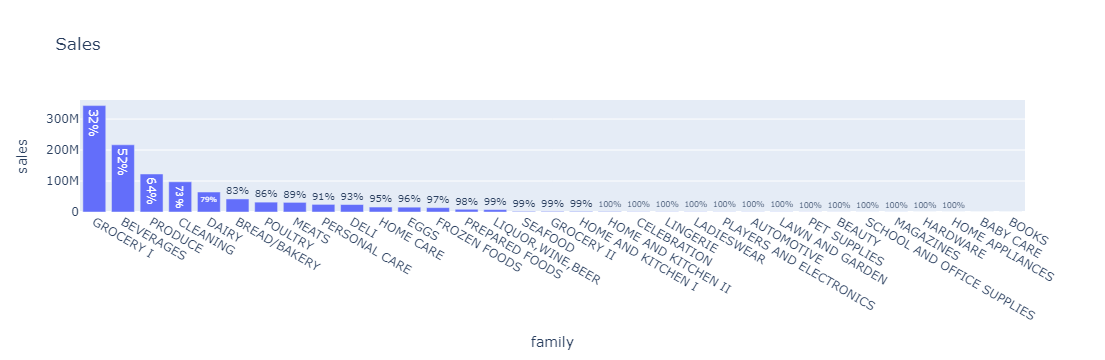

In [11]:
#plot ranked category sales 
fig1 = px.bar(temp, x="family",y="sales",title = "Sales",text="cumulative")
fig1.show()

We decided to group the remaining product families into a family called "OTHERS" to reduce the number of family categories. This will make it easier for us to do regression with dummies later.

In [12]:
#list of the top 5 families
top5 = ['GROCERY I','BEVERAGES','PRODUCE','CLEANING','DAIRY']

#removing the top 5 families so we can get the list of remaining families
tmp = grouped[~grouped['family'].isin(top5)]

#the list of families that we want to group into 'OTHERS'
tmp['family'].unique()

array(['BEAUTY', 'BREAD/BAKERY', 'DELI', 'EGGS', 'FROZEN FOODS',
       'GROCERY II', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
       'MEATS', 'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS',
       'AUTOMOTIVE', 'HARDWARE', 'SEAFOOD', 'HOME APPLIANCES',
       'CELEBRATION', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME CARE', 'MAGAZINES', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'LADIESWEAR',
       'SCHOOL AND OFFICE SUPPLIES', 'BABY CARE', 'BOOKS'], dtype=object)

In [13]:
#replace the above list with 'OTHERS'
trainc = grouped.copy()
trainc['family'] = grouped['family'].replace(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'BREAD/BAKERY',
       'CELEBRATION', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY II',
       'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN',
       'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS',
       'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS',
       'POULTRY', 'PREPARED FOODS', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'],'OTHERS')

newtrain = trainc.groupby(['date', 'cluster', 'family']).sum('sales').reset_index()
newtrain

date  cluster     family        sales
0      2013-01-01        1  BEVERAGES   810.000000
1      2013-01-01        1   CLEANING   186.000000
2      2013-01-01        1      DAIRY   143.000000
3      2013-01-01        1  GROCERY I   700.000000
4      2013-01-01        1     OTHERS   672.618999
...           ...      ...        ...          ...
165214 2017-08-15       17   CLEANING  1357.000000
165215 2017-08-15       17      DAIRY  1377.000000
165216 2017-08-15       17  GROCERY I  4756.000000
165217 2017-08-15       17     OTHERS  3773.369000
165218 2017-08-15       17    PRODUCE  5031.190000

[165219 rows x 4 columns]

In summary, we have now removed the product families which never have sales, clustered the stores into seventeen clusters, and grouped the lower selling product families into "OTHERS". In doing so, we have greatly reduced the number of records in our dataset, which will improve computation and ease in our regression later.

# 3. Descriptive Analytics

In [14]:
newtrain.groupby('family').describe()['sales'].applymap(lambda x: f"{x:.2f}")

count      mean     min      25%      50%       75%        max  \
family                                                                         
BEVERAGES  28398.00   7639.78  242.00  2990.25  5536.50  10469.50   58848.00   
CLEANING   28399.00   3433.97  186.00  1462.00  2846.00   4639.00   22544.00   
DAIRY      28398.00   2270.85   66.00   979.25  1838.00   3022.00   14339.00   
GROCERY I  28398.00  12094.61  700.00  5012.50  9925.00  16164.00  138535.00   
OTHERS     28399.00   8046.55  596.89  3704.74  6454.25  10780.98  105366.90   
PRODUCE    23227.00   5282.85    1.00    82.00  4045.53   7953.38   31994.97   

               std  
family              
BEVERAGES  6686.87  
CLEANING   2545.52  
DAIRY      1764.45  
GROCERY I  9418.56  
OTHERS     6125.40  
PRODUCE    5711.49

The table above shows a brief description of the product families. We will plot our grouped product families to determine the shape of our data and if there are any outliers.

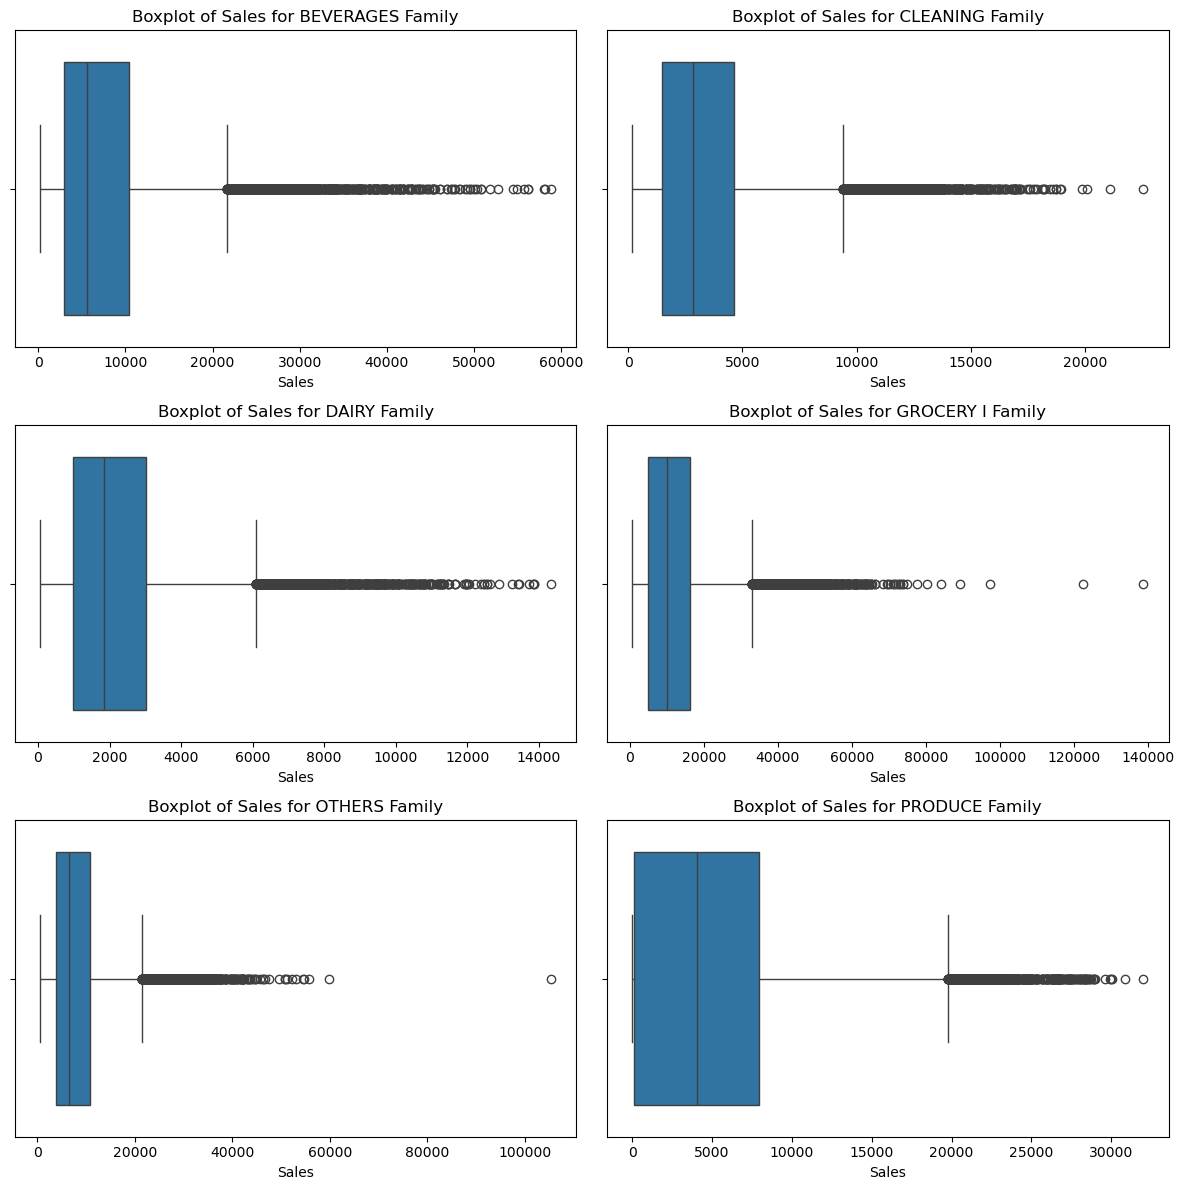

In [15]:
# Create a subplot grid with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten axes for easier indexing
axes = axes.ravel()

# Unique family categories
families = newtrain['family'].unique()

# Plot sales boxplots for different family categories
for i, family in enumerate(families):
    filtered_data = newtrain[newtrain['family'] == family]
    sns.boxplot(data=filtered_data, x='sales', ax=axes[i])
    axes[i].set_xlabel('Sales')
    axes[i].set_title(f'Boxplot of Sales for {family} Family')

# Hide extra subplots
for j in range(len(families), len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Automatically adjust subplot layout to prevent overlap
plt.show()

According to the boxplots shown above, we can conclude that they are highly skewed. Although it is intuitive to think that grocery stores can have some high volume sales occasionally, for simplicity, we have decided to follow the boxplot as our reasoning for removing outliers.

We also note that many of the product families have zero sales. While this could be due to store closure, we cannot ignore the possibility of human errors. However, the existence of these zero sales could be pulling down the averages. As such, we will not completely remove all outliers outside of the boxplots.

## Remove Outliers

In [16]:
#function for removing outliers
def remove_outliers (df) :
    # Calculate the first quartile (Q1)
    q1 = df.groupby('family')['sales'].transform('quantile', 0.25)

    # Calculate the third quartile (Q3)
    q3 = df.groupby('family')['sales'].transform('quantile', 0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = q3 - q1

    # Define the lower and upper bounds for outliers
    lbound = q1 - 1.5 * IQR
    ubound = q3 + 1.5 * IQR

    # Filter the dataset to remove outliers
    no_outliers = df[~((df['sales'] < lbound) | (df['sales'] > ubound))]
    
    return no_outliers

In [17]:
no_outliers = remove_outliers (newtrain)
no_outliers

date  cluster     family        sales
0      2013-01-01        1  BEVERAGES   810.000000
1      2013-01-01        1   CLEANING   186.000000
2      2013-01-01        1      DAIRY   143.000000
3      2013-01-01        1  GROCERY I   700.000000
4      2013-01-01        1     OTHERS   672.618999
...           ...      ...        ...          ...
165214 2017-08-15       17   CLEANING  1357.000000
165215 2017-08-15       17      DAIRY  1377.000000
165216 2017-08-15       17  GROCERY I  4756.000000
165217 2017-08-15       17     OTHERS  3773.369000
165218 2017-08-15       17    PRODUCE  5031.190000

[159331 rows x 4 columns]

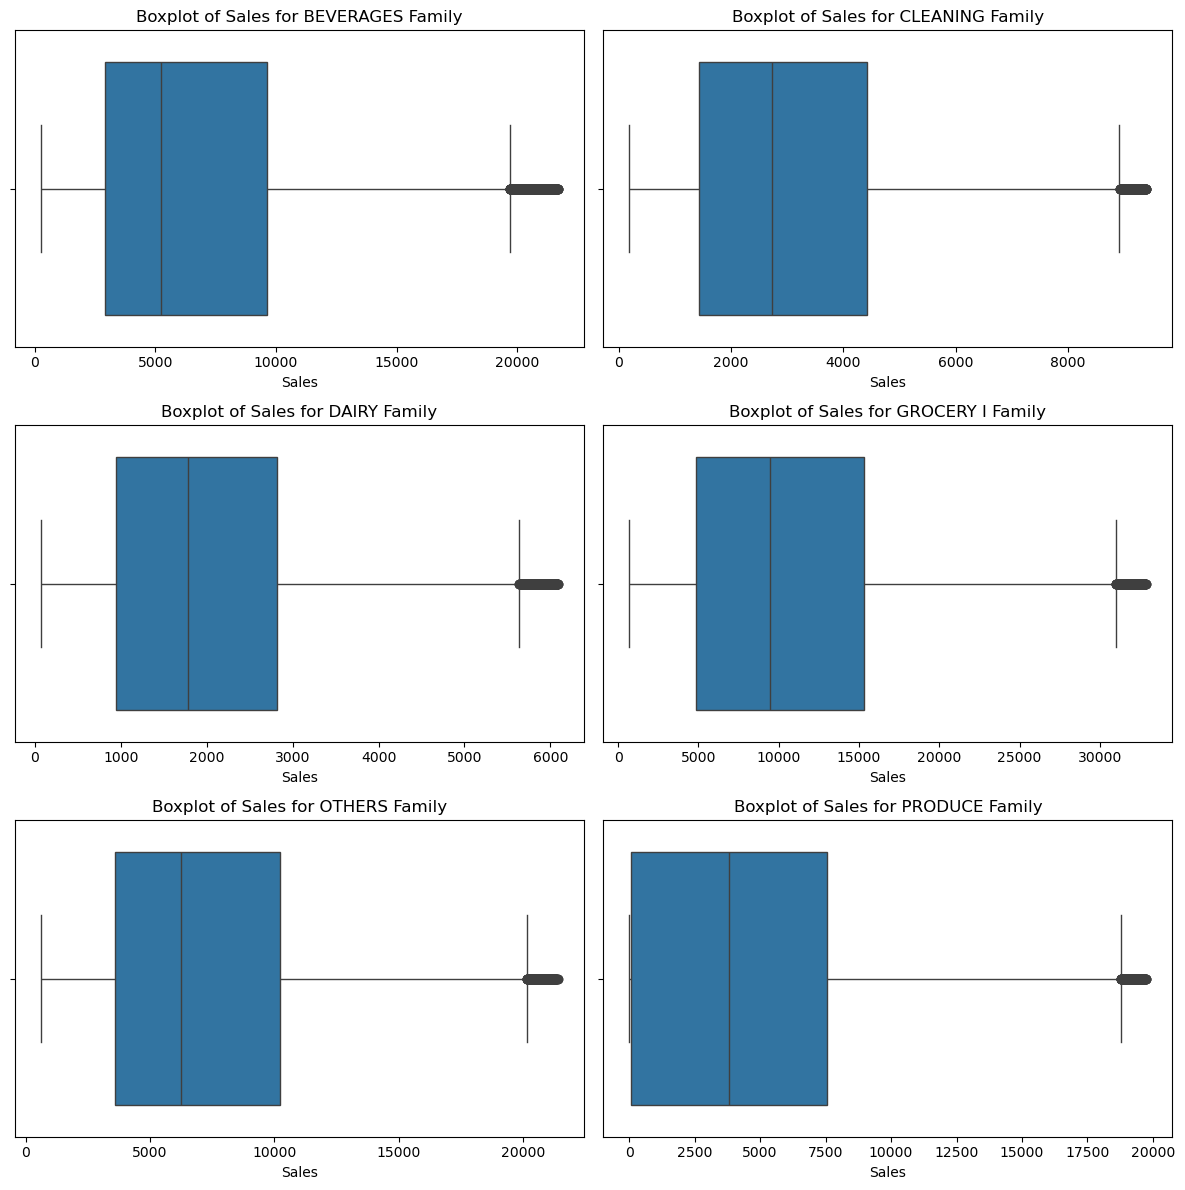

In [18]:
# plot new boxplots for no_outliers

# Create a subplot grid with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten axes for easier indexing
axes = axes.ravel()

# Unique family categories
families = no_outliers['family'].unique()

# Plot sales boxplots for different family categories
for i, f in enumerate(families):
    filtered = no_outliers[no_outliers['family'] == f]
    sns.boxplot(data=filtered, x='sales', ax=axes[i])
    axes[i].set_xlabel('Sales')
    axes[i].set_title(f'Boxplot of Sales for {f} Family')

# Hide extra subplots
for j in range(len(families), len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Automatically adjust subplot layout to prevent overlap
plt.show()

We now have a dataset with reduced outliers.

# 4. Exploratory Data Analysis
Now we can plot graphs for the top five product families and "OTHERS" to determine what kind of regression we should use.

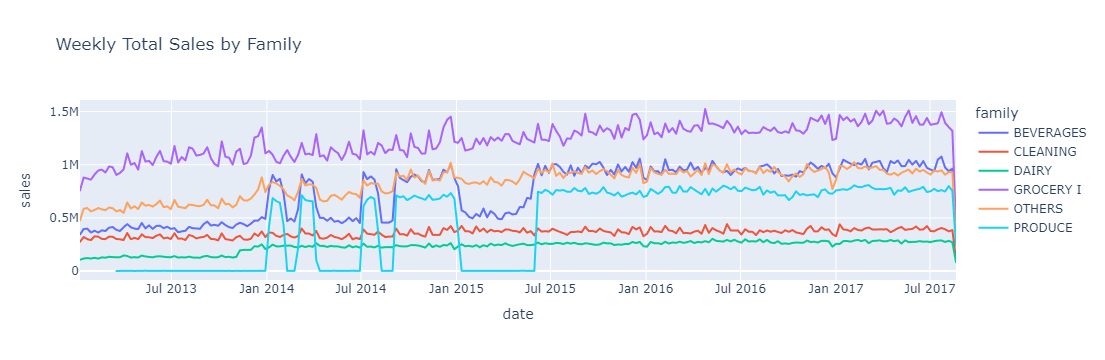

In [19]:
wtrain = no_outliers.set_index("date").groupby("family").resample("W").sales.sum().reset_index()
top6 = ['GROCERY I','BEVERAGES','PRODUCE','CLEANING','DAIRY', 'OTHERS']
cond = wtrain['family'].isin(top6)
px.line(wtrain[cond], x = "date", y = "sales", color = "family", title = "Weekly Total Sales by Family")

The above graph shows clear signs of seasonality by weeks and months, as well as a growing trend in all product families. Interestingly, we can can see two major dips in sales in 2014, as well as in 2015 and August 2017. These dips may be due to major world events, holidays, or oil prices, and although we have been provided with this data, we have chosen to ignore them for now. Perhaps they can be further investigated in the future.

However, produce sales are exhibiting a strange pattern where it appears that it is not making any sales. This will be further investigated in the following graphs.

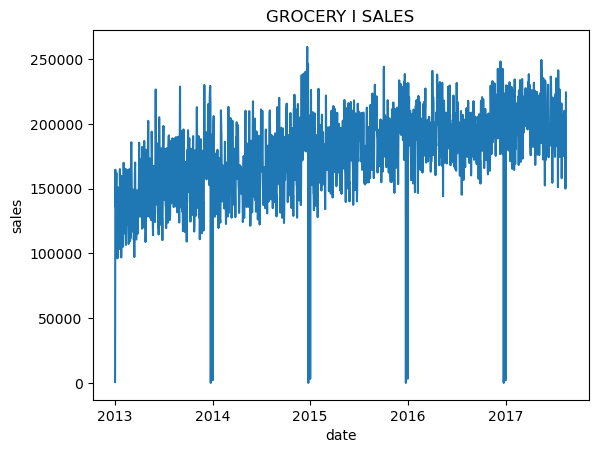

In [20]:
#sns.set(rc={"figure.figsize":(17, 10)}) 
dtrain = no_outliers.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
gfig = sns.lineplot(dtrain[dtrain['family']=='GROCERY I'],x='date',y='sales').set_title('GROCERY I SALES')

The above graph shows grocery I sales over all stores and dates. It clearly depicts daily seasonality and a consistent growing trend. The sales appear to be zero at the start of every year, and this may be related to a holiday or events at the beginning of the year, but we will not be investigating that in this report.

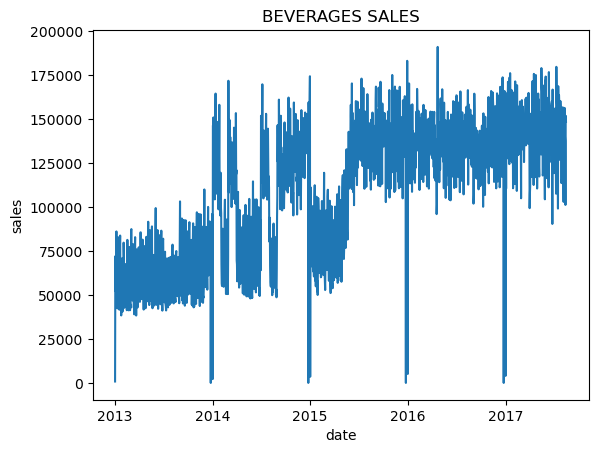

In [21]:
bfig = sns.lineplot(dtrain[dtrain['family']=='BEVERAGES'],x='date',y='sales').set_title('BEVERAGES SALES')

Beverage sales also show a clear seasonality, but the seasonality increases along with the trend in 2014 and 2015, and appears to be stable starting in mid-2015. This could be something that we would need to investigate later. As with grocery I sales, there appears to be no sales at the start of the year.

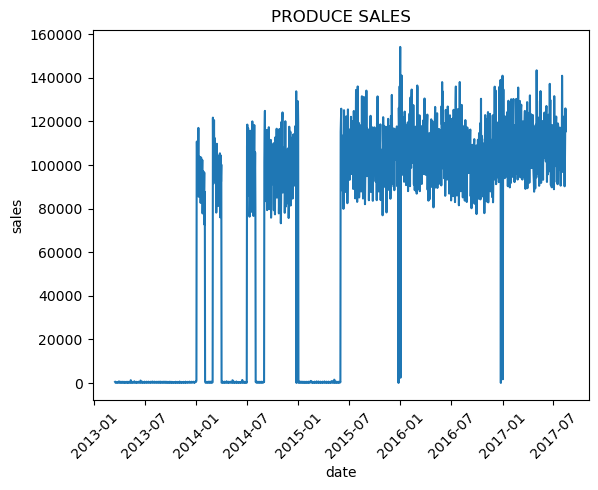

In [22]:
pfig = sns.lineplot(dtrain[dtrain['family']=='PRODUCE'],x='date',y='sales').set_title('PRODUCE SALES')
plt.xticks(rotation=45)
plt.show()

Produce sales exhibit the strangest behaviour. The sales appear to very low in 2013, having multiple spikes in sales, and then decreasing again. The sales continue to be consistent with seasonality and trend starting in mid-2015.

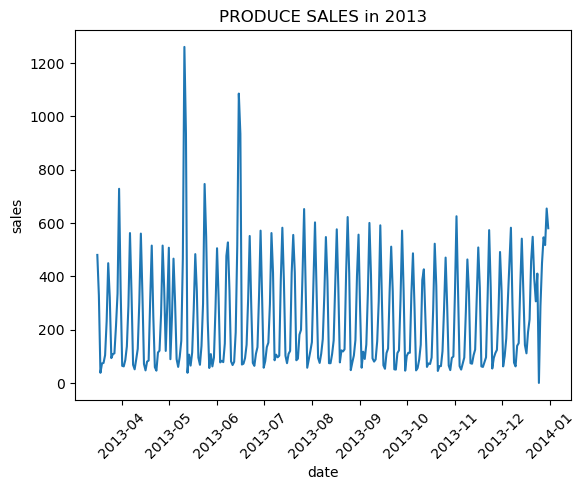

In [23]:
ptrain = dtrain[(dtrain['date'].dt.year == 2013) & (dtrain['family'] == 'PRODUCE')]
pfig2013 = sns.lineplot(ptrain,x='date',y='sales').set_title('PRODUCE SALES in 2013')
plt.xticks(rotation=45)
plt.show()

In the graph above, we take a closer look at the produce sales in 2013. Although the sales are low, it is still showing a clear sign of seasonality.

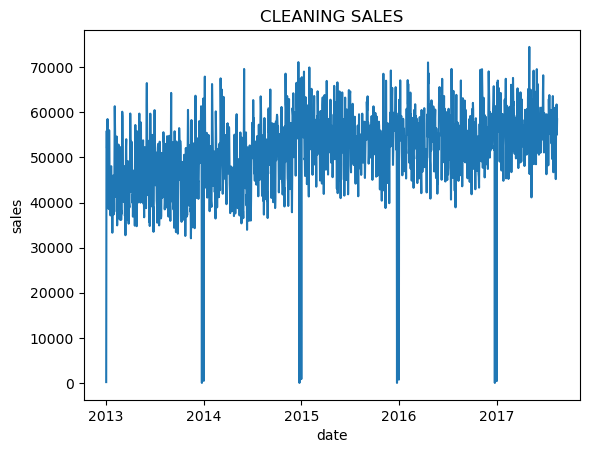

In [24]:
cfig = sns.lineplot(dtrain[dtrain['family']=='CLEANING'],x='date',y='sales').set_title('CLEANING SALES')

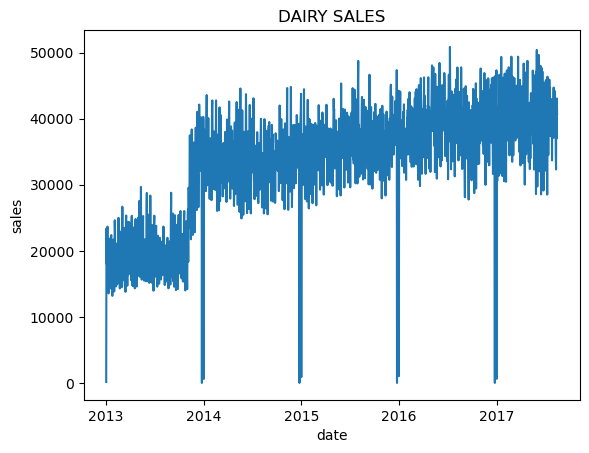

In [25]:
dfig = sns.lineplot(dtrain[dtrain['family']=='DAIRY'],x='date',y='sales').set_title('DAIRY SALES')

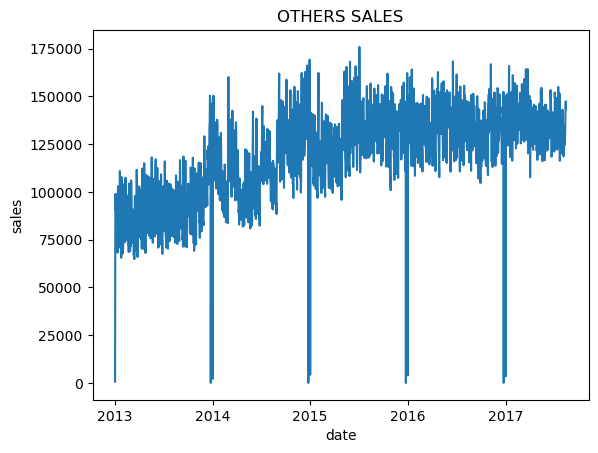

In [26]:
ofig = sns.lineplot(dtrain[dtrain['family']=='OTHERS'],x='date',y='sales').set_title('OTHERS SALES')

Sales for families cleaning, dairy, and others show clear daily seasonality, and a consistent trend.

## The following two figures simply illustrate the total sales or average for each category.

Text(0.5, 1.0, 'Sum Sales by Category')

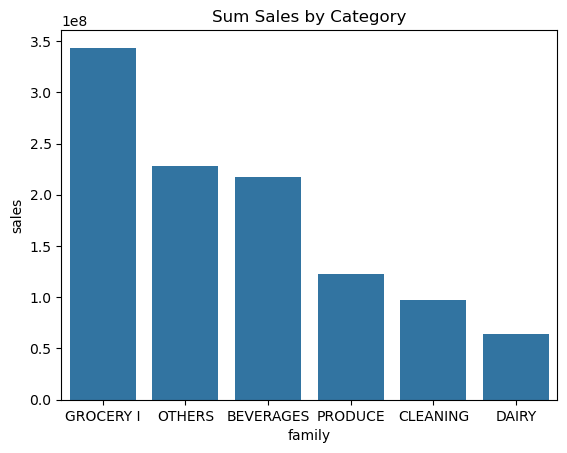

In [27]:
# plot a bar chart
sales_by_family = newtrain.groupby('family')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
sns.barplot(data=sales_by_family, x='family', y='sales').set_title("Sum Sales by Category")

Text(0.5, 1.0, 'Average Sales by Category')

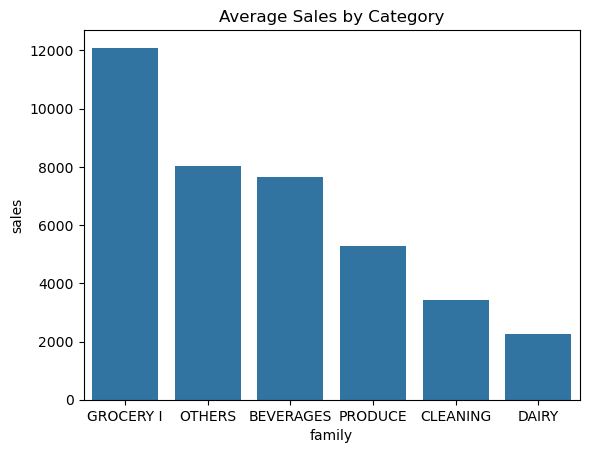

In [28]:
# plot a bar chart
sales_by_family2 = newtrain.groupby('family')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)
sns.barplot(data=sales_by_family2, x='family', y='sales').set_title("Average Sales by Category")

Since there are some seasonalities, we could do some engineering and see if the 'days' in our data means anything

# 5. Seasonality Analysis

Since the above graphs show clear signs of seasonality, we will do some feature engineering to see how the months and days impact sales.

In [29]:
# add numbers for the months, days, and days of the week (Monday is 0)
no_outliers['month'] = no_outliers['date'].dt.month.astype('category')
no_outliers['day_of_month'] = no_outliers['date'].dt.day.astype('category')
no_outliers['day_of_week'] = no_outliers['date'].dt.dayofweek.astype('category')

no_outliers

date  cluster     family        sales month day_of_month  \
0      2013-01-01        1  BEVERAGES   810.000000     1            1   
1      2013-01-01        1   CLEANING   186.000000     1            1   
2      2013-01-01        1      DAIRY   143.000000     1            1   
3      2013-01-01        1  GROCERY I   700.000000     1            1   
4      2013-01-01        1     OTHERS   672.618999     1            1   
...           ...      ...        ...          ...   ...          ...   
165214 2017-08-15       17   CLEANING  1357.000000     8           15   
165215 2017-08-15       17      DAIRY  1377.000000     8           15   
165216 2017-08-15       17  GROCERY I  4756.000000     8           15   
165217 2017-08-15       17     OTHERS  3773.369000     8           15   
165218 2017-08-15       17    PRODUCE  5031.190000     8           15   

       day_of_week  
0                1  
1                1  
2                1  
3                1  
4                1  
...            ...  
165214           1  
165215           1  
165216           1  
165217           1  
165218           1  

[159331 rows x 7 columns]

In [30]:
# replace the categories with numbers, clean train (ct)
ct = no_outliers.copy()
ct['family'] = ct['family'].replace({'GROCERY I': 1, 'BEVERAGES': 2, 'PRODUCE': 3, 'CLEANING': 4, 'DAIRY': 5, 'OTHERS': 6}).astype('category')
ct

date  cluster family        sales month day_of_month day_of_week
0      2013-01-01        1      2   810.000000     1            1           1
1      2013-01-01        1      4   186.000000     1            1           1
2      2013-01-01        1      5   143.000000     1            1           1
3      2013-01-01        1      1   700.000000     1            1           1
4      2013-01-01        1      6   672.618999     1            1           1
...           ...      ...    ...          ...   ...          ...         ...
165214 2017-08-15       17      4  1357.000000     8           15           1
165215 2017-08-15       17      5  1377.000000     8           15           1
165216 2017-08-15       17      1  4756.000000     8           15           1
165217 2017-08-15       17      6  3773.369000     8           15           1
165218 2017-08-15       17      3  5031.190000     8           15           1

[159331 rows x 7 columns]

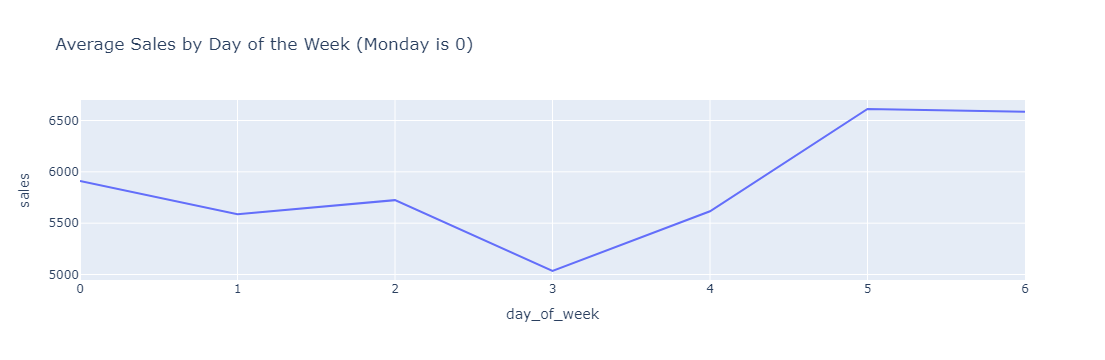

In [31]:
# plot based on day of week
px.line((ct.groupby('day_of_week')['sales'].mean().reset_index()),x='day_of_week',y='sales',title='Average Sales by Day of the Week (Monday is 0)')

The above graph shows how the sales change during the week. It is clear that most sales occur on the weekends, with the lowest sales being on Thursdays. This is indicative of weekly seasonality and we will take this into account when creating dummies later.

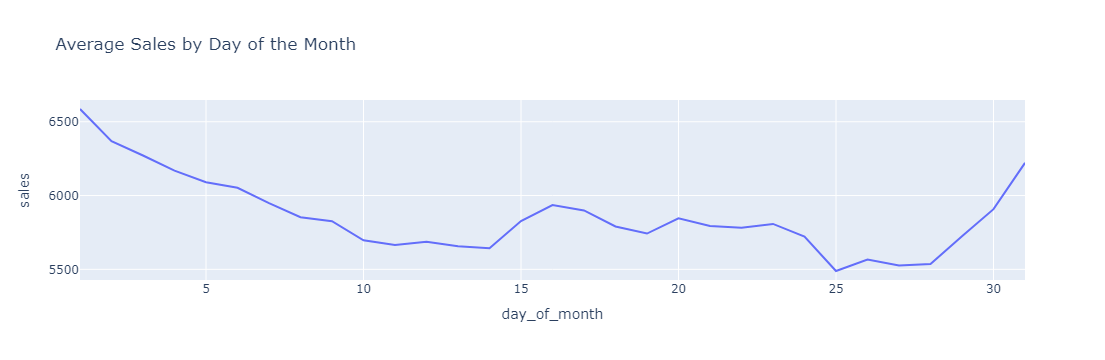

In [32]:
# plot based on day
px.line((ct.groupby('day_of_month')['sales'].mean().reset_index()),x='day_of_month',y='sales',title='Average Sales by Day of the Month')

The above graph shows how the sales change during the days of the month. The source data states that wages in the public sector are paid every two weeks on the 15th and last day of the month. This could be the reason why the average sales are higher in the days following payday. This is indicative of daily seasonality and we will also take this into account when creating our dummies.

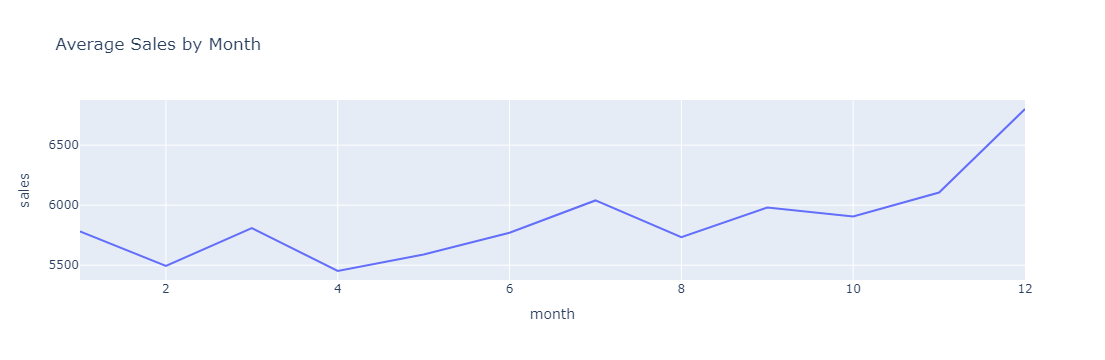

In [33]:
# plot based on month
px.line((ct.groupby('month')['sales'].mean().reset_index()),x='month',y='sales',title='Average Sales by Month')

The above graph shows that sales are generally higher in November and December, indicative of monthly seasonality. We have decided to leave the months as is.

As the data is exhibiting daily, weekly, and monthly seasonality, we should include these variables into our model. However, including all seven days of the week, 28-31 days of the month, and all twelve months of the year would lead to too many predictor variables, in addition to the six product families that have already been reduced.

To reduce the number of variables, we have decided to focus only on if the day of the week is a weekend, and if the day of the month is four days within paycheck.

As for the clusters, a regression with dummies should be run for each one.

## Creating Dummies

In [34]:
#data frames where we are trying to reduce variables

#make a new data frame with a binary variable if the day is within 4 days of pay day
#1 if the day is within 4 days of pay day, 0 if not
fourdays = pd.DataFrame({
    'day_of_month': range(1, 32),
    '4d_within_pay': [1 if x in [15, 16, 17, 18, 30, 31, 1, 2, 3] 
                     else 0 for x in range(1, 32)]
})

#make a new data frame with a binary variable if the day is a weekday
#1 if it's a weekend, 0 if not
wkends = pd.DataFrame({
    'day_of_week': range(7),
    'weekend': [0 if x in [0, 1, 2, 3, 4] 
                else 1 for x in range(7)]
})

In [35]:
#merge the tables to turn day into a dummy variable based on the above conditions
join1 = ct.merge(fourdays, on='day_of_month', how='left', indicator=False)

#merge the tables to turn day of the week into a dummy variable based on the above conditions
join2 = join1.merge(wkends, on='day_of_week', how='left', indicator=False)

#training with dummies (td), removing the day of the month and week
td = join2.drop(['day_of_month', 'day_of_week'], axis=1)
td

date  cluster family        sales month  4d_within_pay  weekend
0      2013-01-01        1      2   810.000000     1              1        0
1      2013-01-01        1      4   186.000000     1              1        0
2      2013-01-01        1      5   143.000000     1              1        0
3      2013-01-01        1      1   700.000000     1              1        0
4      2013-01-01        1      6   672.618999     1              1        0
...           ...      ...    ...          ...   ...            ...      ...
159326 2017-08-15       17      4  1357.000000     8              1        0
159327 2017-08-15       17      5  1377.000000     8              1        0
159328 2017-08-15       17      1  4756.000000     8              1        0
159329 2017-08-15       17      6  3773.369000     8              1        0
159330 2017-08-15       17      3  5031.190000     8              1        0

[159331 rows x 7 columns]

Now we can make dummies for each product family and each month, and our model is finally ready for regression.

In [36]:
#dummies for family
fdum = pd.get_dummies(td, columns=['family'])

#dummies for months
mdum = pd.get_dummies(fdum, columns = ['month'])

#since dummies are booleans, cycle through all columns, check if bool, then change to int
for col in mdum:
    if mdum[col].dtype == bool:
         mdum[col] = mdum[col].astype(int)
mdum.columns.tolist()

['date',
 'cluster',
 'sales',
 '4d_within_pay',
 'weekend',
 'family_1',
 'family_2',
 'family_3',
 'family_4',
 'family_5',
 'family_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [37]:
mdum.head()

date  cluster       sales  4d_within_pay  weekend  family_1  family_2  \
0 2013-01-01        1  810.000000              1        0         0         1   
1 2013-01-01        1  186.000000              1        0         0         0   
2 2013-01-01        1  143.000000              1        0         0         0   
3 2013-01-01        1  700.000000              1        0         1         0   
4 2013-01-01        1  672.618999              1        0         0         0   

   family_3  family_4  family_5  ...  month_3  month_4  month_5  month_6  \
0         0         0         0  ...        0        0        0        0   
1         0         1         0  ...        0        0        0        0   
2         0         0         1  ...        0        0        0        0   
3         0         0         0  ...        0        0        0        0   
4         0         0         0  ...        0        0        0        0   

   month_7  month_8  month_9  month_10  month_11  month_12  
0        0        0        0         0         0         0  
1        0        0        0         0         0         0  
2        0        0        0         0         0         0  
3        0        0        0         0         0         0  
4        0        0        0         0         0         0  

[5 rows x 23 columns]

# 6. Model 1: Linear Regression

We will now attempt to perform linear regression on the following dataset with dummies. As we are treating each cluster separately, we will run linear regression on each cluster.

In [38]:
train_m1 = mdum.copy()

In [39]:
#function for running linear regression
def lin_reg (df, c):
    y = df['sales']
    
    #exclude family_6 and month_12 
    x = df[[
     '4d_within_pay',
     'weekend',
     'family_1',
     'family_2',
     'family_3',
     'family_4',
     'family_5',
     'month_1',
     'month_2',
     'month_3',
     'month_4',
     'month_5',
     'month_6',
     'month_7',
     'month_8',
     'month_9',
     'month_10',
     'month_11',
    ]]
    
    x = sm.add_constant(x)
    
    model = sm.OLS(y, x).fit()
    
    #plotting the residual and normal probability plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={"color": "red"}, ax=axes[0])
    axes[0].set_xlabel('Predicted Sales')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title(f'Residual Plot for Cluster {c}')

    sm.qqplot(model.resid, line='s', ax=axes[1])
    axes[1].set_xlabel('Predicted Sales')
    axes[1].set_ylabel('Actual Sales')
    axes[1].set_title(f'Normal Probability Plot for Cluster {c}')
    
    plt.tight_layout
    plt.show
    
    return model


Regression Results for Cluster 1

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     630.3
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:05:52   Log-Likelihood:                -92275.
No. Observations:               10026   AIC:                         1.846e+05
Df Residuals:                   10007   BIC:                         1.847e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const      

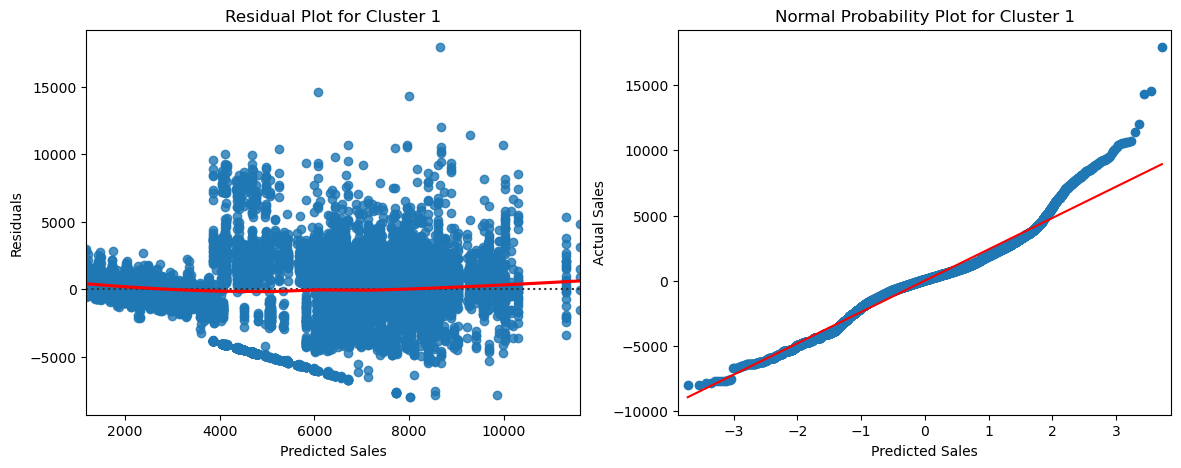

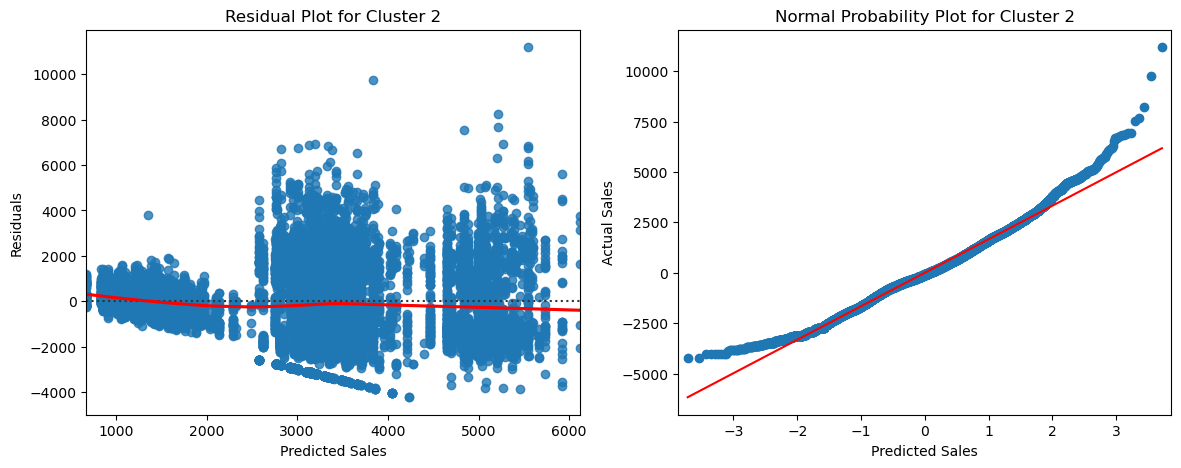

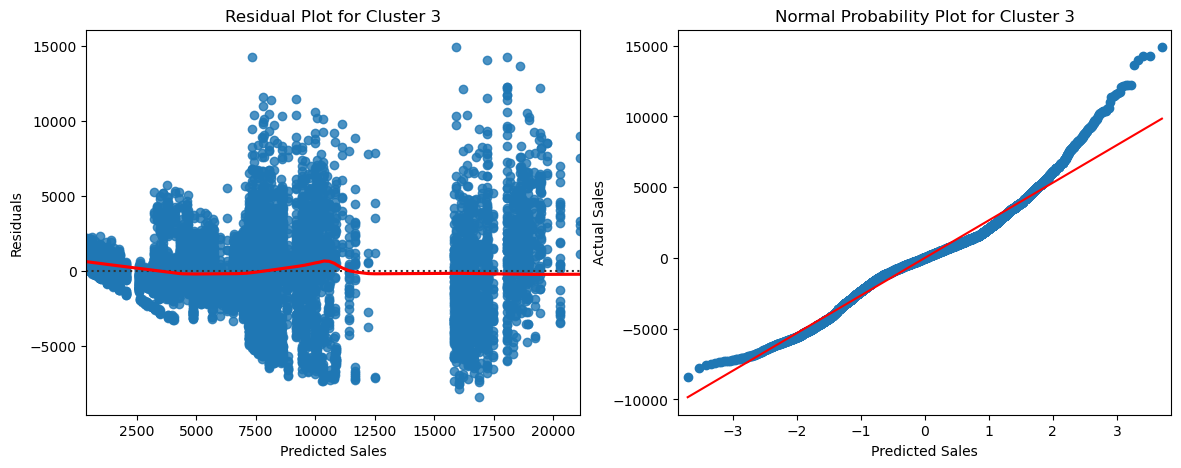

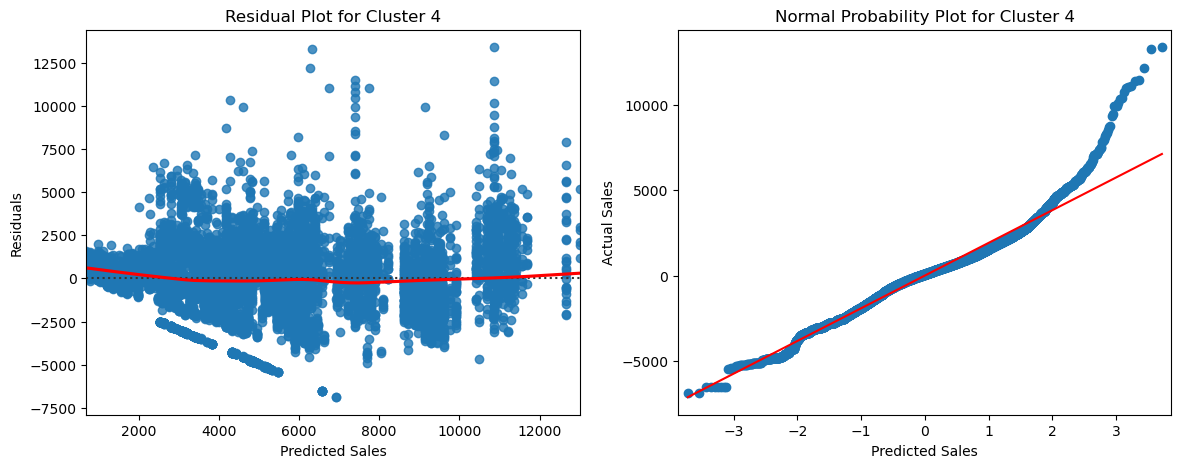

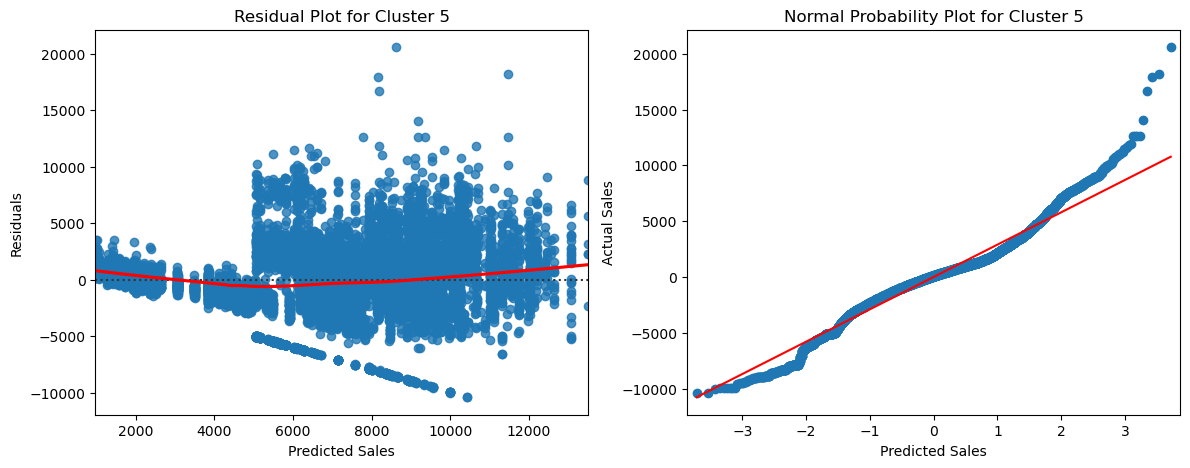

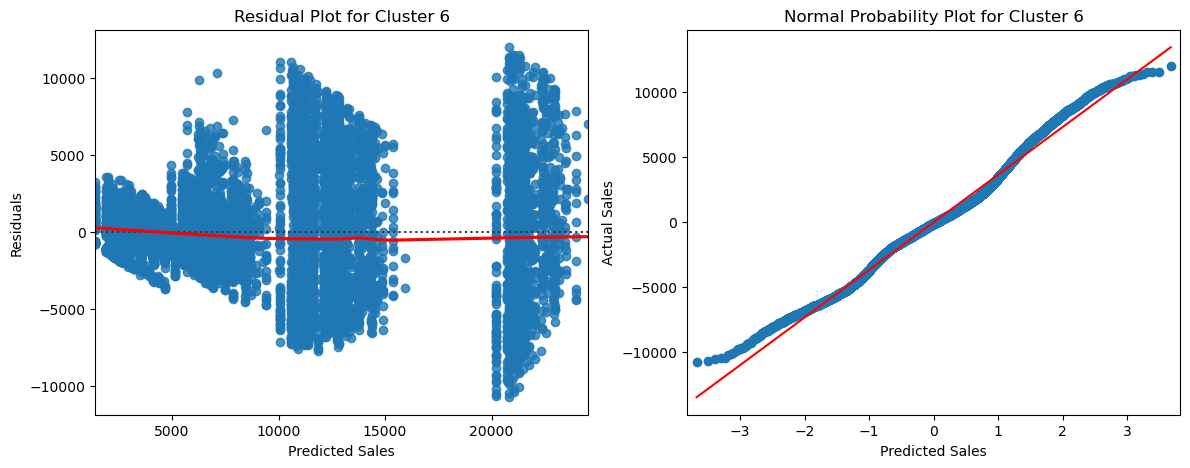

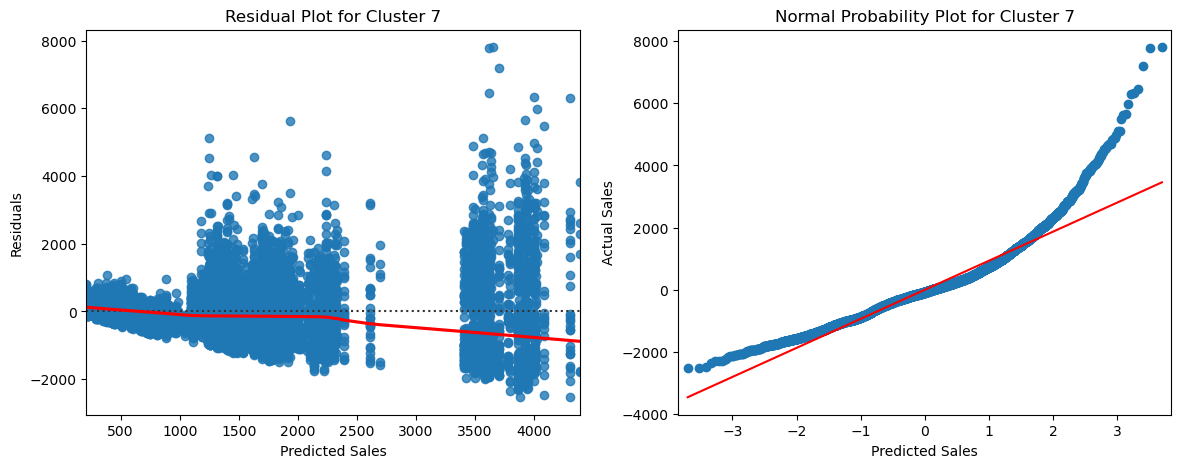

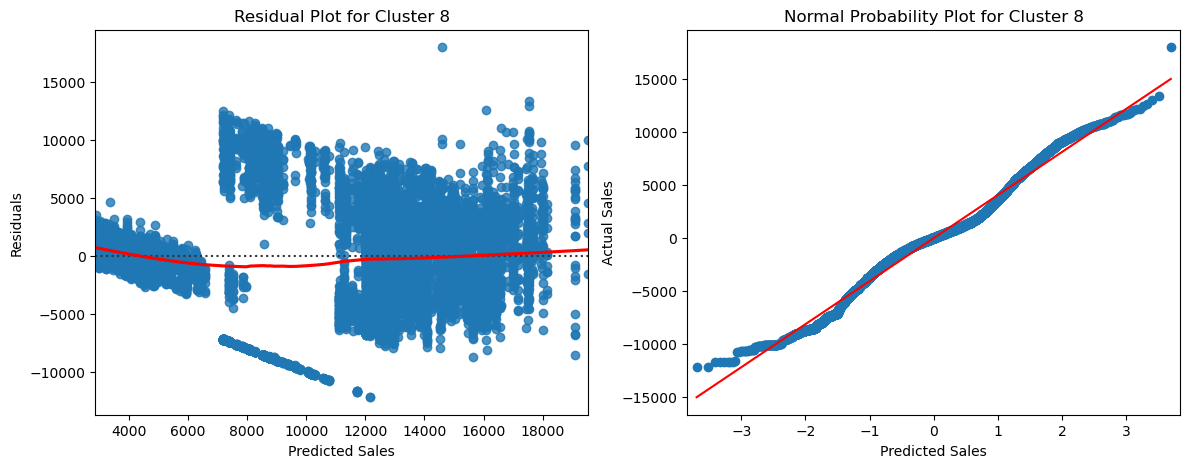

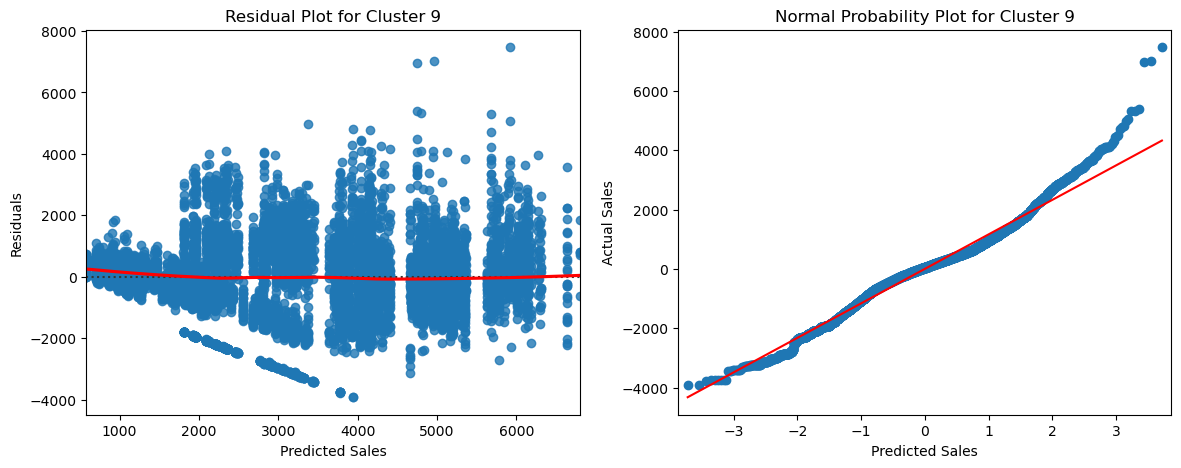

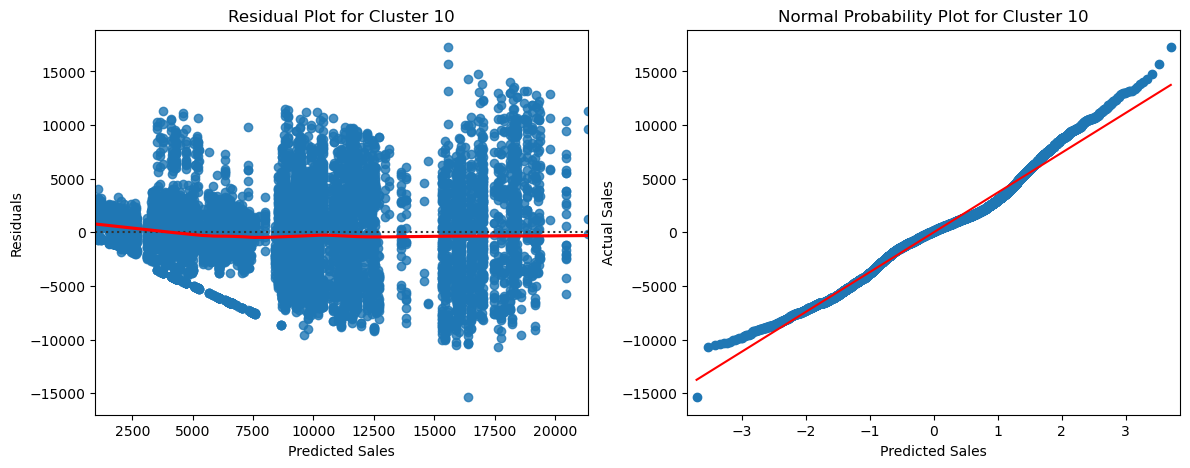

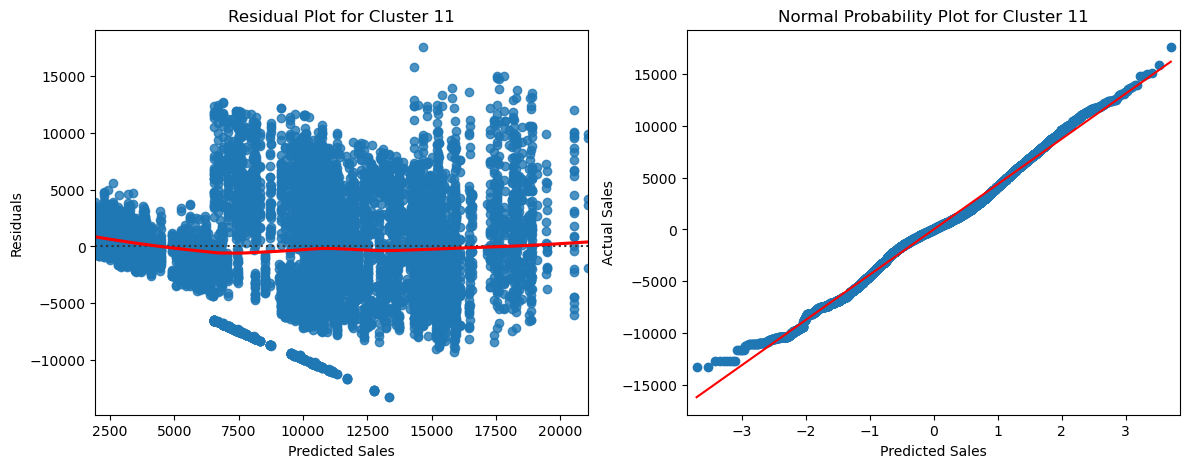

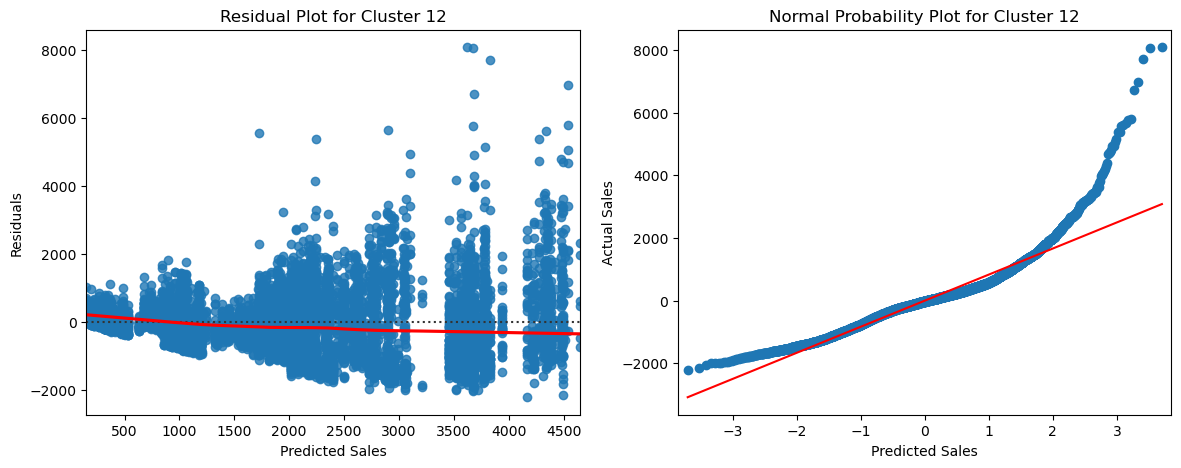

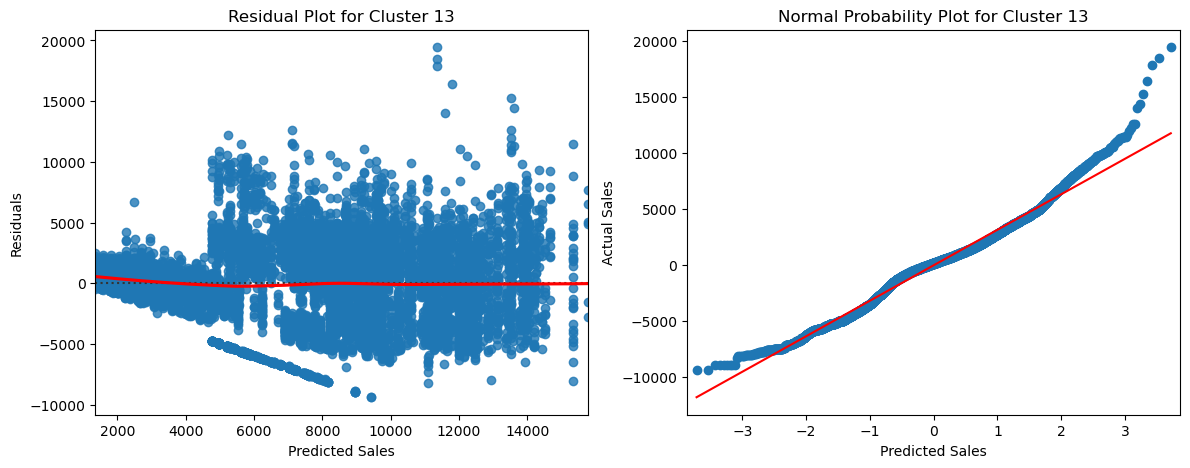

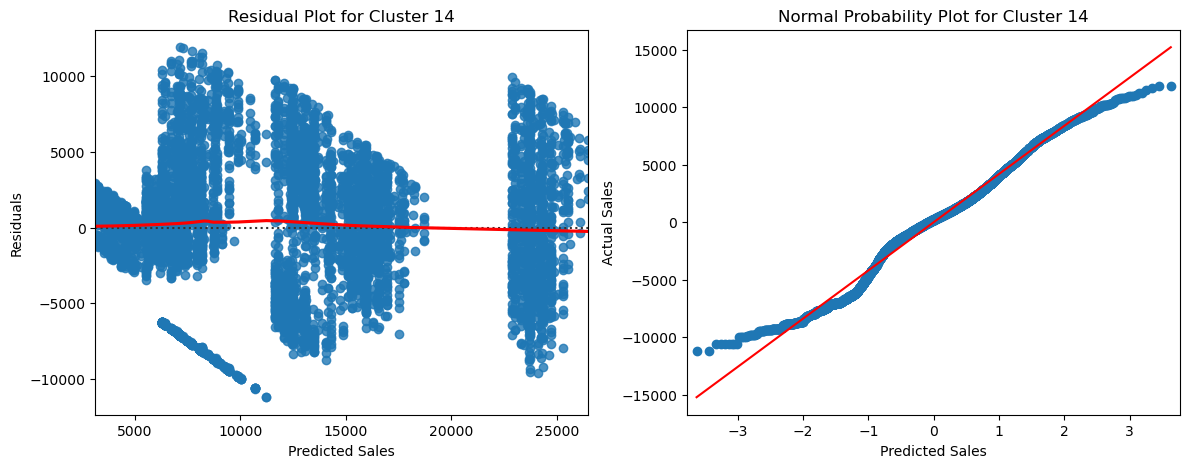

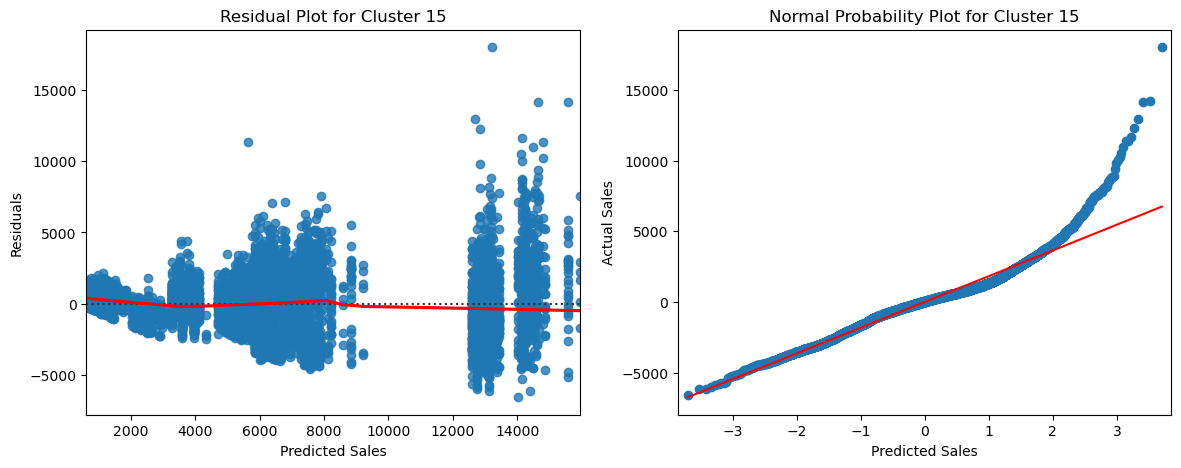

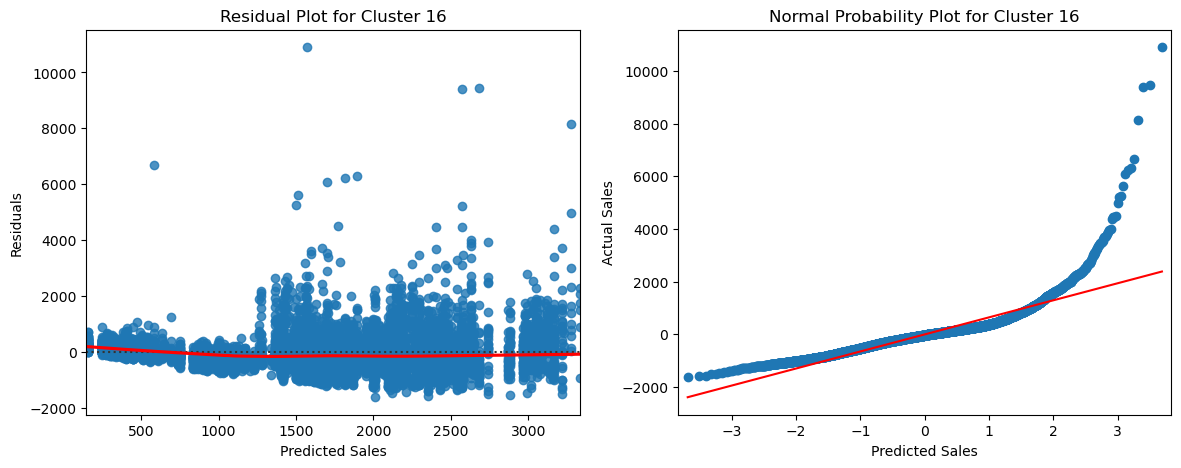

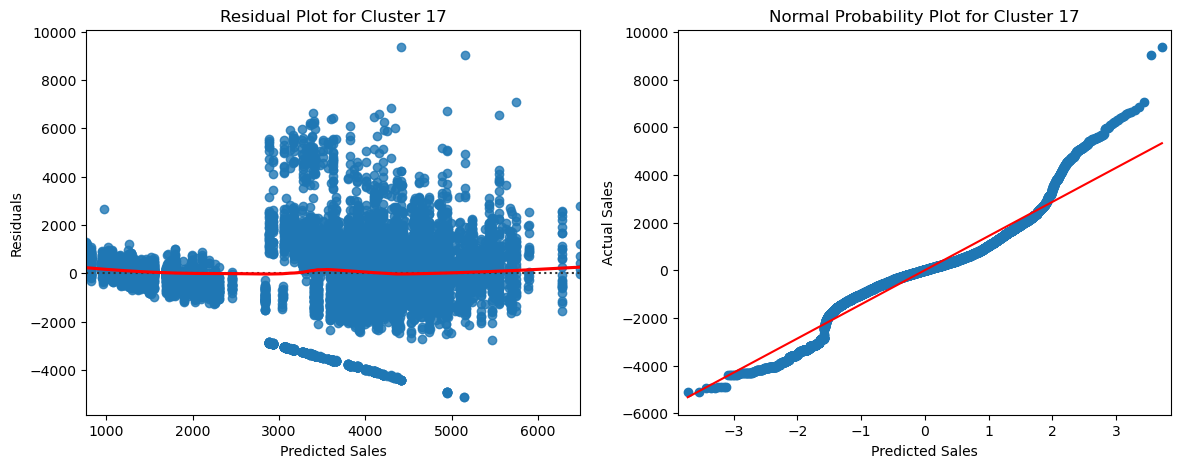

In [40]:
#cycling through the clusters and running linear regression on each one
for c in range(1,18):
    result = lin_reg(train_m1[train_m1['cluster'] == c], c)
    print("\nRegression Results for Cluster " + str(c) + "\n")
    print(result.summary())

## Discussion of Model 1

The purpose of model 1 was to see if there was a linear relationship in sales over time. As this is the most basic method of regression, this would help us determine what our next steps should be. If the model performed well, we could then use linear regression to forecast the sales. However, this model proved to be poor and we can see this during the data cleaning process, adjusted R-squared, and residual and normal probability plots.

First, data processing took a considerable amount of time. As stated above, there are 54 stores and 33 product families, which already create too many different variables in our data, forcing us to cluster and group. There is also seasonality to deal with, and for us to do this with multiple regression, we had to create dummies, which again creates way too many variables. In order not to violate parsimony, having too many variables is not a good idea, and the amount of processing that needed to be done just to prepare the dataset for linear regression was inefficient. As the seasonality appeared to be additive, we could have explored an exponential smoothing method such as Holt-Winters, but we have chosen not to pursue it here.

As our model included many predictor variables, we will look at the adjusted R-squared values, which were poor for each cluster run with linear regression. Although some clusters output an adjusted R-squared value above 0.7, which is considered to be good, majority presented with R-squared values around 0.5. This means that about 50% of the time, our model does not capture the variations in number of sales. However, the p-values for the predictor variables in all runs were less than 0.05, indicating that they are significant.

A first look at the residual plot for cluster 1 shows that the points are randomized, and the normal probability plot is almost a straight line. These are representations of a good model. However, as we continue to look through the residual plots, we notice that there does appear to be a pattern among them. Although we are not able to define this pattern based on our knowledge of different types of regression, the pattern does prove that the linear regression model we have used is not a good fit. Some of the normal probability plots are also exhibiting exponential growth, most notably, the plots for clusters 12, 15, and 16. In this case, we could try using an exponential trend model by taking the logarithm of sales, but due to time restraints and the fact that we know the regression model is not a good fit here, we have chosen not to explore the exponential trend at this time.

We have concluded that model 1 is not a good model for forecasting the stores sales in this dataset due to the amount of variables, adjusted R-squared, and residual plots. However, we do note that this model was created after we omitted other variables such as promotion, holidays, and oil prices from our analysis. Had we chosen to include those, we may have received better results, but at this time we will not be using it to make any predictions, and will instead move on to another technique which could potentially give us better results.

# 7. Model 2: Random Forest

Our second approach to creating a model for forecasting store sales in Random Forest. In summary, Random Forest is a supervised learning and ensemble algorithm that is an extension of decision trees. It can be used both on classification and regression models with high accuracy, and is able to handle large datasets efficiently. However, it is black-box model as we cannot really interpret the individual decision trees within the random forest.

Random Forest is able to handle many stores, product families, and seasonality within our data, so we will not need to worry about grouping, creating dummies, and taking the logarithm of sales. As such, we can go back and look at our unprocessed data. Thankfully, there is a package for Random Forest that we can import without having to go into the specifics of breaking down our decision trees.

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 

In [42]:
train

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [43]:
# use original train dataset and drop all the zero sales value
train_rf = join[~(join._merge == 'both')].drop(['id', '_merge'], axis = 1).reset_index()
train_rf = train_rf.drop(['index'], axis=1)
train_rf 

date  store_nbr                      family     sales  \
0       2013-01-01         25                      BEAUTY     2.000   
1       2013-01-01         25                   BEVERAGES   810.000   
2       2013-01-01         25                BREAD/BAKERY   180.589   
3       2013-01-01         25                    CLEANING   186.000   
4       2013-01-01         25                       DAIRY   143.000   
...            ...        ...                         ...       ...   
2061753 2017-08-15          9                     POULTRY   438.133   
2061754 2017-08-15          9              PREPARED FOODS   154.553   
2061755 2017-08-15          9                     PRODUCE  2419.729   
2061756 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
2061757 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
2061753            0  
2061754            1  
2061755          148  
2061756            8  
2061757            0  

[2061758 rows x 5 columns]

In [44]:
rotrain = remove_outliers(train_rf)
rotrain['codetime'] = (rotrain['date'] - rotrain['date'].min()).dt.days
rotrain['month'] = rotrain['date'].dt.month
rotrain['day'] = rotrain['date'].dt.day
rotrain['day_of_week'] = rotrain['date'].dt.dayofweek
train2 = rotrain.copy()

## Preprocessing the Categorical Variables and Removing Outliers

In [45]:
#use train 2
train2

date  store_nbr                   family     sales  onpromotion  \
0       2013-01-01         25                   BEAUTY     2.000            0   
1       2013-01-01         25                BEVERAGES   810.000            0   
2       2013-01-01         25             BREAD/BAKERY   180.589            0   
3       2013-01-01         25                 CLEANING   186.000            0   
4       2013-01-01         25                    DAIRY   143.000            0   
...            ...        ...                      ...       ...          ...   
2061752 2017-08-15          9  PLAYERS AND ELECTRONICS     6.000            0   
2061753 2017-08-15          9                  POULTRY   438.133            0   
2061754 2017-08-15          9           PREPARED FOODS   154.553            1   
2061755 2017-08-15          9                  PRODUCE  2419.729          148   
2061757 2017-08-15          9                  SEAFOOD    16.000            0   

         codetime  month  day  day_of_week  
0               0      1    1            1  
1               0      1    1            1  
2               0      1    1            1  
3               0      1    1            1  
4               0      1    1            1  
...           ...    ...  ...          ...  
2061752      1687      8   15            1  
2061753      1687      8   15            1  
2061754      1687      8   15            1  
2061755      1687      8   15            1  
2061757      1687      8   15            1  

[1931233 rows x 9 columns]

In model 1, we had grouped the product families together before removing the outliers, but now we will remove the outliers while keep all the families as they are.

The random forest package requires all categorical variables to be changed into numerical variables, so we will add dummies for each family.

In [46]:
train2.info()
train2_dummy = pd.get_dummies(train2, columns=['family'])
train2_dummy

<class 'pandas.core.frame.DataFrame'>
Index: 1931233 entries, 0 to 2061757
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   codetime     int64         
 6   month        int32         
 7   day          int32         
 8   day_of_week  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3), object(1)
memory usage: 125.2+ MB


date  store_nbr     sales  onpromotion  codetime  month  day  \
0       2013-01-01         25     2.000            0         0      1    1   
1       2013-01-01         25   810.000            0         0      1    1   
2       2013-01-01         25   180.589            0         0      1    1   
3       2013-01-01         25   186.000            0         0      1    1   
4       2013-01-01         25   143.000            0         0      1    1   
...            ...        ...       ...          ...       ...    ...  ...   
2061752 2017-08-15          9     6.000            0      1687      8   15   
2061753 2017-08-15          9   438.133            0      1687      8   15   
2061754 2017-08-15          9   154.553            1      1687      8   15   
2061755 2017-08-15          9  2419.729          148      1687      8   15   
2061757 2017-08-15          9    16.000            0      1687      8   15   

         day_of_week  family_AUTOMOTIVE  family_BABY CARE  ...  \
0                  1              False             False  ...   
1                  1              False             False  ...   
2                  1              False             False  ...   
3                  1              False             False  ...   
4                  1              False             False  ...   
...              ...                ...               ...  ...   
2061752            1              False             False  ...   
2061753            1              False             False  ...   
2061754            1              False             False  ...   
2061755            1              False             False  ...   
2061757            1              False             False  ...   

         family_MAGAZINES  family_MEATS  family_PERSONAL CARE  \
0                   False         False                 False   
1                   False         False                 False   
2                   False         False                 False   
3                   False         False                 False   
4                   False         False                 False   
...                   ...           ...                   ...   
2061752             False         False                 False   
2061753             False         False                 False   
2061754             False         False                 False   
2061755             False         False                 False   
2061757             False         False                 False   

         family_PET SUPPLIES  family_PLAYERS AND ELECTRONICS  family_POULTRY  \
0                      False                           False           False   
1                      False                           False           False   
2                      False                           False           False   
3                      False                           False           False   
4                      False                           False           False   
...                      ...                             ...             ...   
2061752                False                            True           False   
2061753                False                           False            True   
2061754                False                           False           False   
2061755                False                           False           False   
2061757                False                           False           False   

         family_PREPARED FOODS  family_PRODUCE  \
0                        False           False   
1                        False           False   
2                        False           False   
3                        False           False   
4                        False           False   
...                        ...             ...   
2061752                  False           False   
2061753                  False           False   
2061754                   True           False   
2061755                  False            

In [47]:
# model training with RandomForest
Xrf = train2_dummy.drop(['sales','date'], axis=1)
yrf = train2_dummy['sales']

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xrf, yrf, test_size=0.3)

# creating the RandomForest model (hyperparameter temporarily set to: n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rfmodel = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)

# training the model
rfresult = rfmodel.fit(X_train, y_train) 

In [48]:
# test the random forest model for the test part of dataset train2_dummy
y_pred = rfmodel.predict(X_test)

print('The model score is: ',rfmodel.score(X_test,y_test))

The model score is:  0.9152205993594735


In [49]:
# RMSE
#y_pred = rfmodel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print(mse)
print(rmse)

79761.39541681691
282.42060019909474


In [50]:
# RMSLE for train2_dummy

log_actual = np.log1p(y_test)
log_pred = np.log1p(y_pred)

rmsle = np.sqrt(np.mean((log_pred - log_actual) ** 2))
rmsle
print("RMSLE:", rmsle)

RMSLE: 1.4544136101067064


In [51]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 79761.39541681691
Mean Absolute Error: 134.47227389968972
R-squared: 0.9152205993594735


In [52]:
#functions for calculating performance measures
def adj_rsquared (r2, n, p) :
    adj_r2 = 1 - ((1-r2) * (n-1) / (n-p-1))
    return adj_r2

adj_r2 = adj_rsquared(r2_score(y_test, y_pred), len(y_test), len(X_test.columns))
print("Adj R-squared:", adj_r2)


Adj R-squared: 0.9152148920827488


In [79]:
from sklearn.linear_model import LinearRegression

# Train the Linear Regression model
lr_model = LinearRegression()

# Using the same training data as the Random Forest model
lr_model.fit(X_train, y_train)

# Make predictions using the Linear Regression model
y_pred_lr = lr_model.predict(X_test)

# Print out the R^2 score for comparison
print('Linear Regression model score:', lr_model.score(X_test, y_test))


Linear Regression model score: 0.7178416790869757


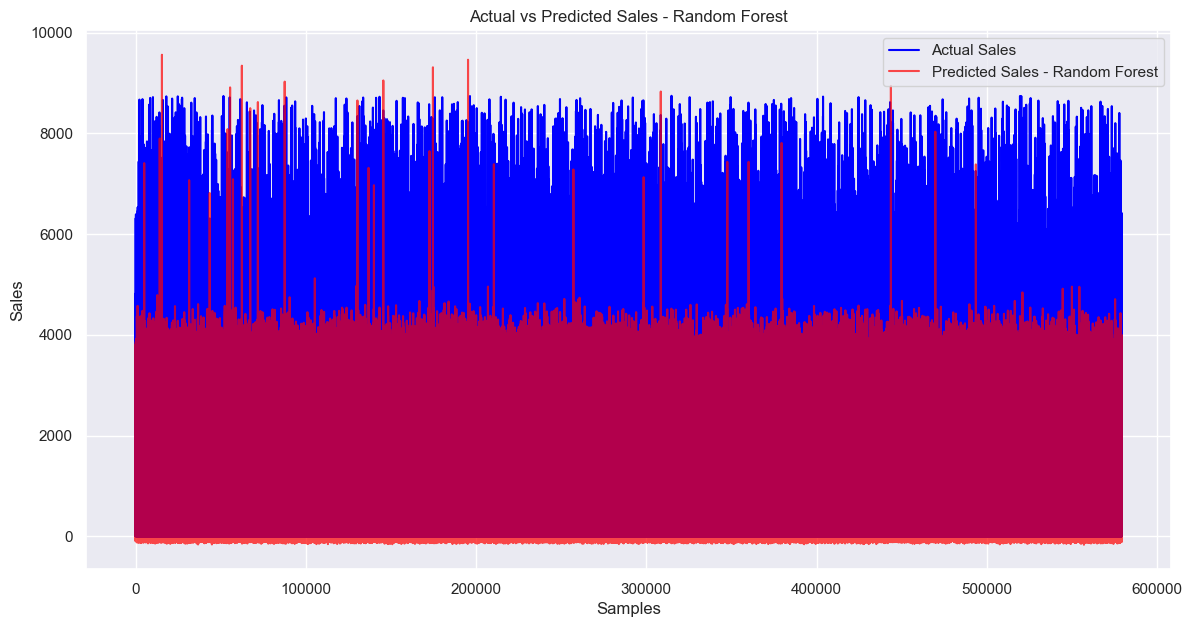

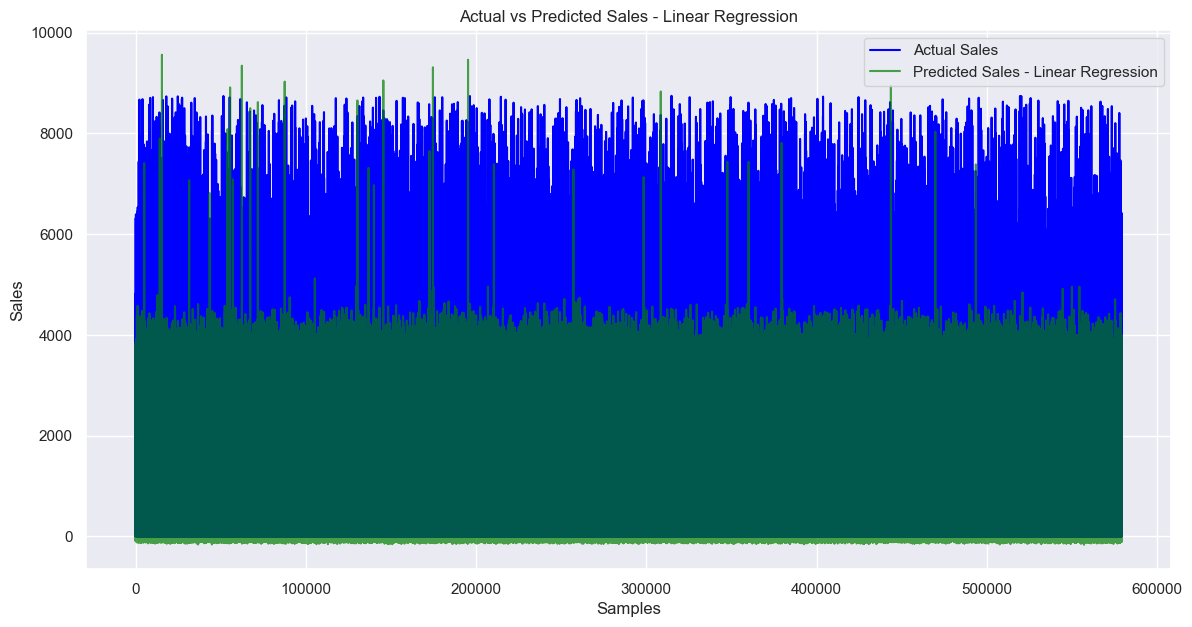

In [81]:
import matplotlib.pyplot as plt

# Plot for Random Forest Model
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(y_pred_lr, label='Predicted Sales - Random Forest', color='red', alpha=0.7)
plt.title('Actual vs Predicted Sales - Random Forest')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot for Linear Regression Model
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(y_pred_lr, label='Predicted Sales - Linear Regression', color='green', alpha=0.7)
plt.title('Actual vs Predicted Sales - Linear Regression')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()


## Discussion of Model 2
Model 2 performed much better than model 1 and we will evaluate the data processing, performance measures, and residual plots to see why it performed better.

Upon looking at the adjuested R-squared for model 2, it is much higher than the adjusted R-squared values we received from model 1 at 0.9. This means that 90% of the variance in sales can be explained by store number and product family. Although we were not able to see any p-values or coefficients, we were able to calculate RMSE which can be compared to other models should we decide to create them in the future.

The residual plot for random forest shows a definite pattern, although we are not able to determine what it is. These patterns may stem from other predictor variables such as promotion, holidays, and oil sales which we were not able to include in this analysis.

We were not able to investigate further into the trends exhibited in our random forest model, but we will conclude that model 2 performed better than model at forecasting stores sales.

# 8. Other Features of Random Forest

## Hyperparameter Optimization

In [53]:
# Hyperparameter tuning
X_train.shape

(1351863, 39)

In [54]:
# set options for the hyperparameters
param_grid = { 
    'n_estimators': [25, 50, 80,100,120,150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [5,7,10,12,15,20,None], 
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 7]
} 

In [55]:
# GridSearchCV takes way too long to run, could be hours
"""grid_search = GridSearchCV(RandomForestRegressor(), 
                           param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) """

'grid_search = GridSearchCV(RandomForestRegressor(), \n                           param_grid=param_grid) \ngrid_search.fit(X_train, y_train) \nprint(grid_search.best_estimator_) '

In [56]:
# so we use RandomizedSearchCV
rand_search = RandomizedSearchCV(RandomForestRegressor(), 
                           param_distributions=param_grid,verbose=2,n_jobs=-1) 

In [57]:
# run for the optimal paramaters, but it's still taking too long to run (6600+s), so we are just putting the result in next cell: 
#rand_search.fit(X_train, y_train) 
#print(rand_search.best_params_) 

In [58]:
# {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}

In [59]:
# check the score for train and test sets, result is 0.94951 and 0.94528
#print(rand_search.score(X_train,y_train))
#print(rand_search.score(X_test,y_test))

In [60]:
# use new hyperparameters to fit the model
rfmodel2 = RandomForestRegressor(n_estimators=120, max_depth=12, n_jobs=-1,min_samples_split=2, min_samples_leaf=1)

# re-training the model
rfresult2 = rfmodel2.fit(X_train, y_train) 

In [61]:
y_pred2 = rfmodel2.predict(X_test)

print('The model score is: ',rfmodel2.score(X_test,y_test))

The model score is:  0.9448563713935617


In [62]:
# RMSLE for train2_dummy

log_actual = np.log1p(y_test)
log_pred2 = np.log1p(y_pred2)

rmsle2 = np.sqrt(np.mean((log_pred2 - log_actual) ** 2))
print("RMSLE:", rmsle2)

RMSLE: 1.1709012731733999


The score after the tuning is 0.945, higher than the score before 0.916. And the RMSLE now is 1.17 comparing to 1.45

Reference: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/, https://www.youtube.com/watch?v=SctFnD_puQI

## Feature Importance

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

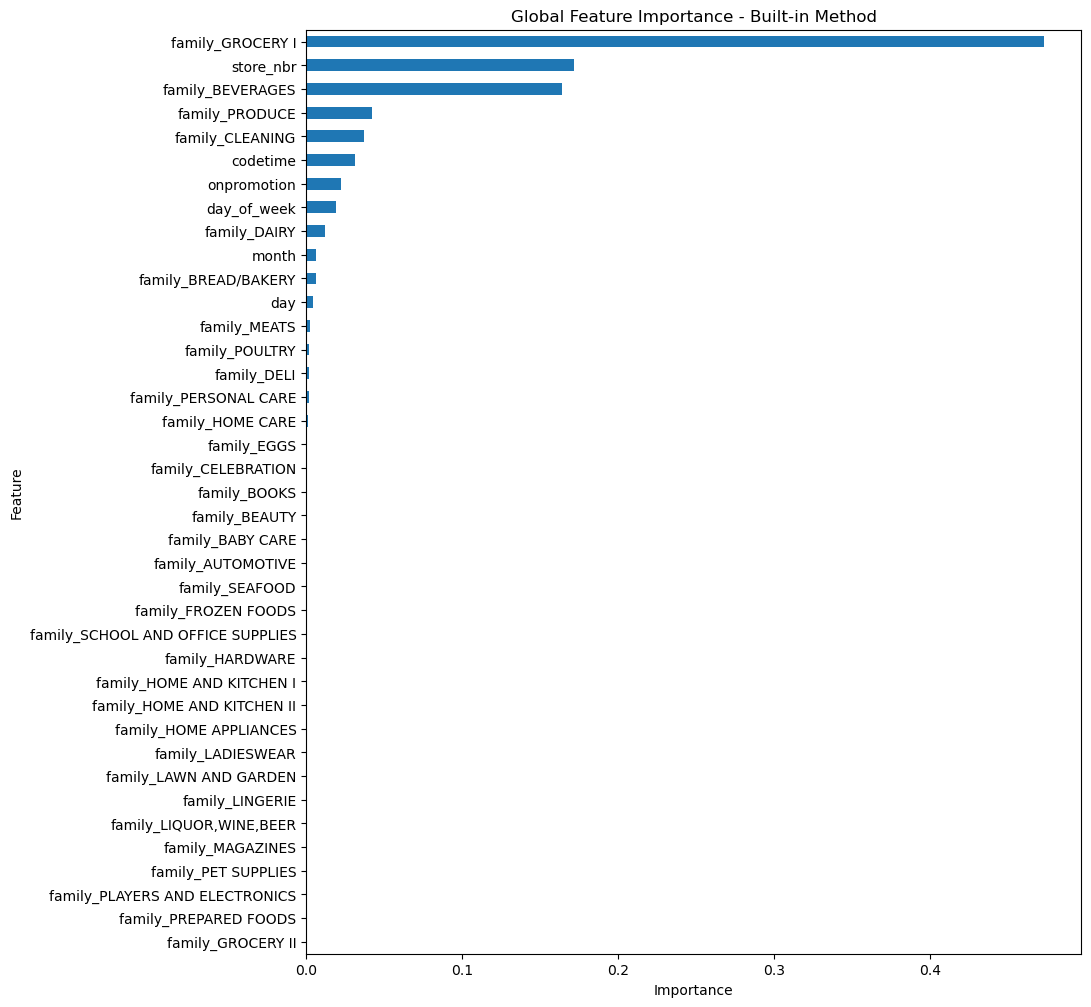

In [63]:
# global feature importance
global_importances = pd.Series(rfmodel2.feature_importances_, index=X_train.columns)
# global_importances
global_importances.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(10, 12)) 
global_importances.plot.barh()

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

So GROCERY I matters the most, followed by store number as the second, then BEVERAGES... However, it is important to note in random forest, there could be a cardinality bias. This bias is a common problem in Random Forest models, where the model tends to overestimate the importance of features with a high number of unique values. How to get feature importance in random forests: https://forecastegy.com/posts/feature-importance-in-random-forests/

## Residual Plot

In [64]:
y_pred_se =pd.Series(y_pred2)
y_pred_se

0           27.901871
1           27.901871
2           27.901871
3           27.901871
4           27.901871
             ...     
579365      27.901871
579366     293.070780
579367    1179.836331
579368      27.901871
579369     825.067524
Length: 579370, dtype: float64

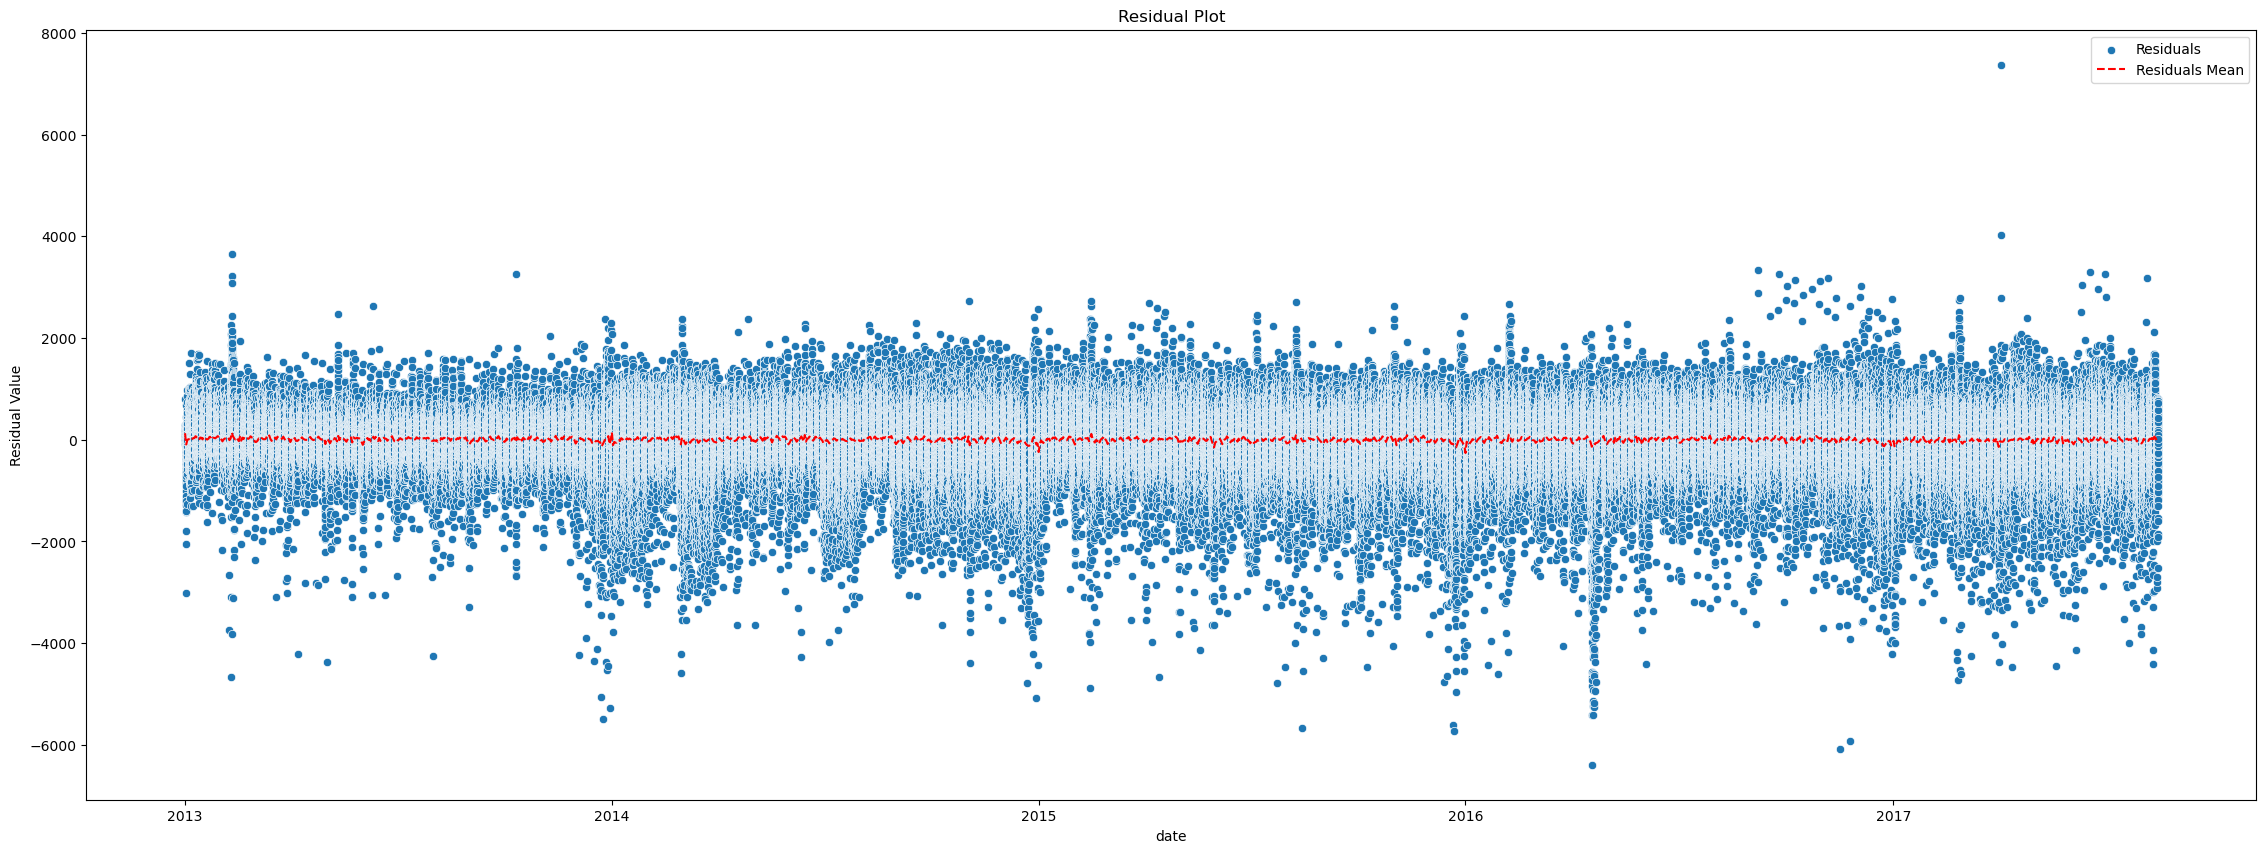

In [65]:
# Calculate residuals
residuals = rfmodel2.predict(Xrf) - yrf

# Create a DataFrame for residuals
residuals_df = pd.DataFrame({'date': train2_dummy['date'], 'residuals': residuals})

# Calculate mean residuals by date
residuals_mean_by_date = residuals_df.groupby('date')['residuals'].mean()

# Convert Series to DataFrame
residuals_mean_df = residuals_mean_by_date.reset_index()
residuals_mean_df.columns = ['date', 'mean_residuals']

# Plot residuals
plt.figure(figsize=(28, 10))
sns.scatterplot(x=train2_dummy['date'], y=residuals, label='Residuals')

# Plot mean residuals
sns.lineplot(data=residuals_mean_df, x='date', y='mean_residuals', color='r', linestyle='--', label='Residuals Mean')

# Set labels and title
plt.ylabel('Residual Value')
plt.title('Residual Plot')
plt.legend()

# Show plot
plt.show()


In [66]:
 residuals_df

date   residuals
0       2013-01-01   25.901871
1       2013-01-01  110.660095
2       2013-01-01  175.160459
3       2013-01-01  297.599705
4       2013-01-01  114.491555
...            ...         ...
2061752 2017-08-15   21.901871
2061753 2017-08-15   90.911487
2061754 2017-08-15 -126.651129
2061755 2017-08-15  -64.457678
2061757 2017-08-15   11.901871

[1931233 rows x 2 columns]

In [67]:
def merge_array_with_df(array, df,column_name='predict'):
    array_series = pd.Series(array, index=df.index)    
    array_series.name = column_name
    # merge df and series
    merged_df = pd.concat([df, array_series], axis=1)
    
    return merged_df


In [68]:
# combine predict sales with test dataset using our created function merge_array_with_df
train2_dummy_pred = merge_array_with_df(y_pred2, y_test)
train2_dummy_pred

sales      predict
775292      3.000    27.901871
1306846     1.000    27.901871
1101032    50.000    27.901871
1399859     1.000    27.901871
1772137   151.445    27.901871
...           ...          ...
1351014   168.000    27.901871
1220612   329.000   293.070780
65145    1082.000  1179.836331
128994      5.000    27.901871
452148   1174.000   825.067524

[579370 rows x 2 columns]

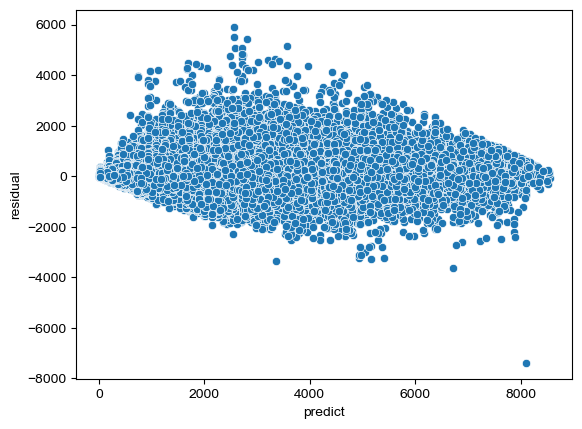

In [69]:
train2_dummy_pred['residual'] = train2_dummy_pred['sales'] - train2_dummy_pred['predict']
sns.scatterplot(train2_dummy_pred,x='predict',y='residual')
sns.set(rc={"figure.figsize":(10, 10)}) 
plt.show()

## Make Prediction Sales & Plots

In [70]:
# make predictions using dataset: test
test

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [71]:
# create a function to process the dataset into our desired form 
def process_dataframe(df):    
    df_processed = df[['date', 'store_nbr', 'family',  'onpromotion']]
    df_processed['codetime'] = (df_processed['date'] - df_processed['date'].min()).dt.days
    df_processed['month'] = df_processed['date'].dt.month
    df_processed['day'] = df_processed['date'].dt.day
    df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
    df_processed_dummy = pd.get_dummies(df_processed, columns=['family'])
    df_processed_dummy = df_processed_dummy.drop(columns=['date']) 
    return df_processed_dummy

In [72]:
processed_df = process_dataframe(test)
processed_df.head()

store_nbr  onpromotion  codetime  month  day  day_of_week  \
0          1            0         0      8   16            2   
1          1            0         0      8   16            2   
2          1            2         0      8   16            2   
3          1           20         0      8   16            2   
4          1            0         0      8   16            2   

   family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  family_BEVERAGES  ...  \
0               True             False          False             False  ...   
1              False              True          False             False  ...   
2              False             False           True             False  ...   
3              False             False          False              True  ...   
4              False             False          False             False  ...   

   family_MAGAZINES  family_MEATS  family_PERSONAL CARE  family_PET SUPPLIES  \
0             False         False                 False                False   
1             False         False                 False                False   
2             False         False                 False                False   
3             False         False                 False                False   
4             False         False                 False                False   

   family_PLAYERS AND ELECTRONICS  family_POULTRY  family_PREPARED FOODS  \
0                           False           False                  False   
1                           False           False                  False   
2                           False           False                  False   
3                           False           False                  False   
4                           False           False                  False   

   family_PRODUCE  family_SCHOOL AND OFFICE SUPPLIES  family_SEAFOOD  
0           False                              False           False  
1           False                              False           False  
2           False                              False           False  
3           False                              False           False  
4           False                              False           False  

[5 rows x 39 columns]

In [73]:
# test the random forest model for the test part of dataset train2_dummy
y_test_pred = rfmodel2.predict(processed_df)
y_test_pred

array([27.90187144, 27.90187144, 27.90187144, ...,  3.94991565,
       27.90187144, 27.90187144])

In [74]:
# combine predict sales with test dataset using our created function merge_array_with_df
testset_pred = merge_array_with_df(y_test_pred, test)
testset_pred
# 0 is the column name for prediction sales

id       date  store_nbr                      family  onpromotion  \
0      3000888 2017-08-16          1                  AUTOMOTIVE            0   
1      3000889 2017-08-16          1                   BABY CARE            0   
2      3000890 2017-08-16          1                      BEAUTY            2   
3      3000891 2017-08-16          1                   BEVERAGES           20   
4      3000892 2017-08-16          1                       BOOKS            0   
...        ...        ...        ...                         ...          ...   
28507  3029395 2017-08-31          9                     POULTRY            1   
28508  3029396 2017-08-31          9              PREPARED FOODS            0   
28509  3029397 2017-08-31          9                     PRODUCE            1   
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9   
28511  3029399 2017-08-31          9                     SEAFOOD            0   

           predict  
0        27.901871  
1        27.901871  
2        27.901871  
3      1931.077373  
4        27.901871  
...            ...  
28507   269.504445  
28508    27.901871  
28509     3.949916  
28510    27.901871  
28511    27.901871  

[28512 rows x 6 columns]

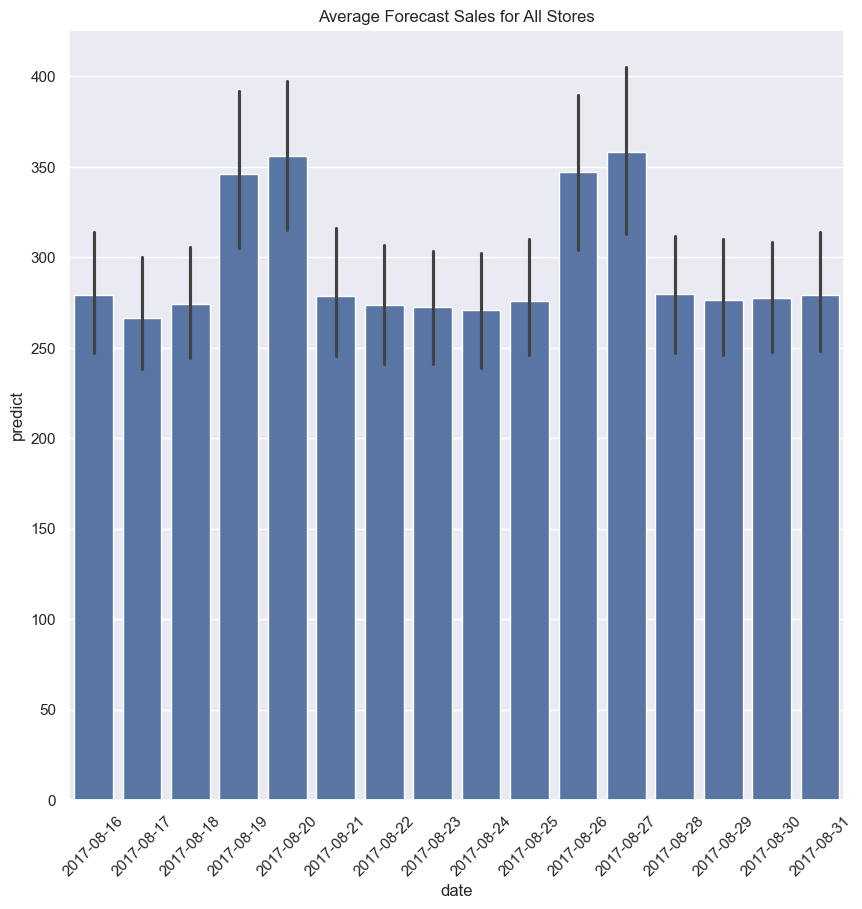

In [75]:
sns.barplot(testset_pred,x='date',y='predict').set_title('Average Forecast Sales for All Stores')
plt.xticks(rotation=45)
plt.show()

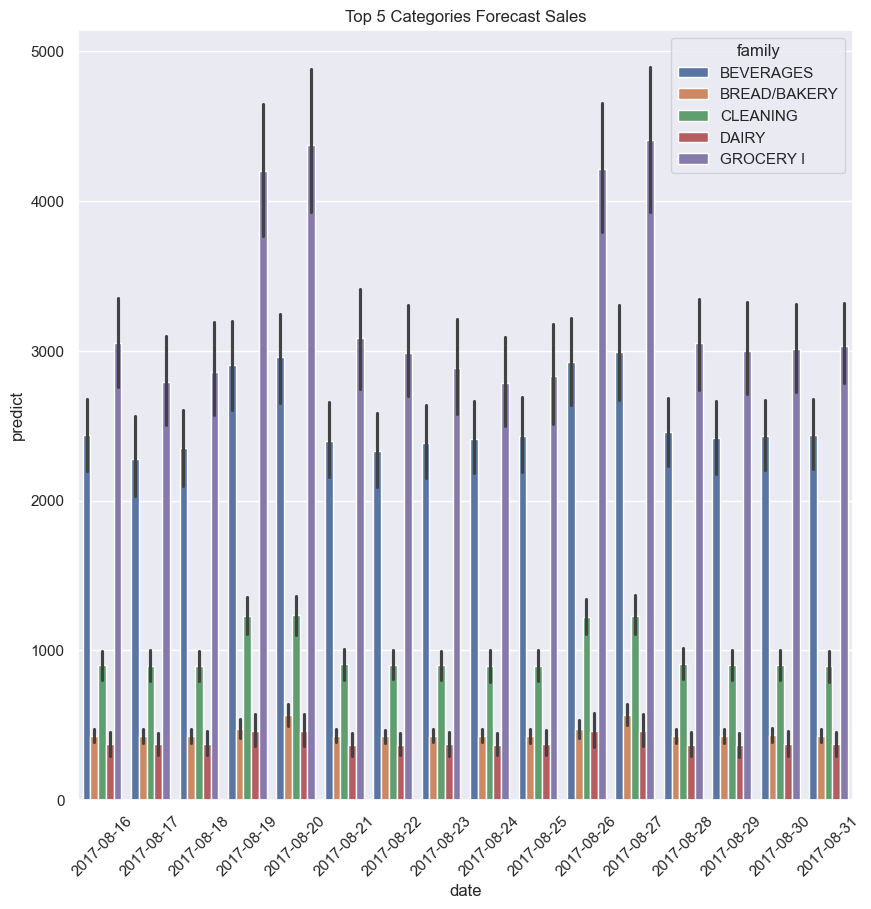

In [76]:
# Top 5 Categories Forecast Sales
mean_by_family = testset_pred.groupby('family')['predict'].sum()

# select only the top 5 categories in 'family'
top_5_families = mean_by_family.nlargest(5).index
top_5_data = testset_pred[testset_pred['family'].isin(top_5_families)]

sns.barplot(data=top_5_data, x='date', y='predict', hue='family').set_title('Top 5 Categories Forecast Sales')
sns.set(rc={"figure.figsize":(35, 10)}) 
plt.xticks(rotation=45)
plt.show()

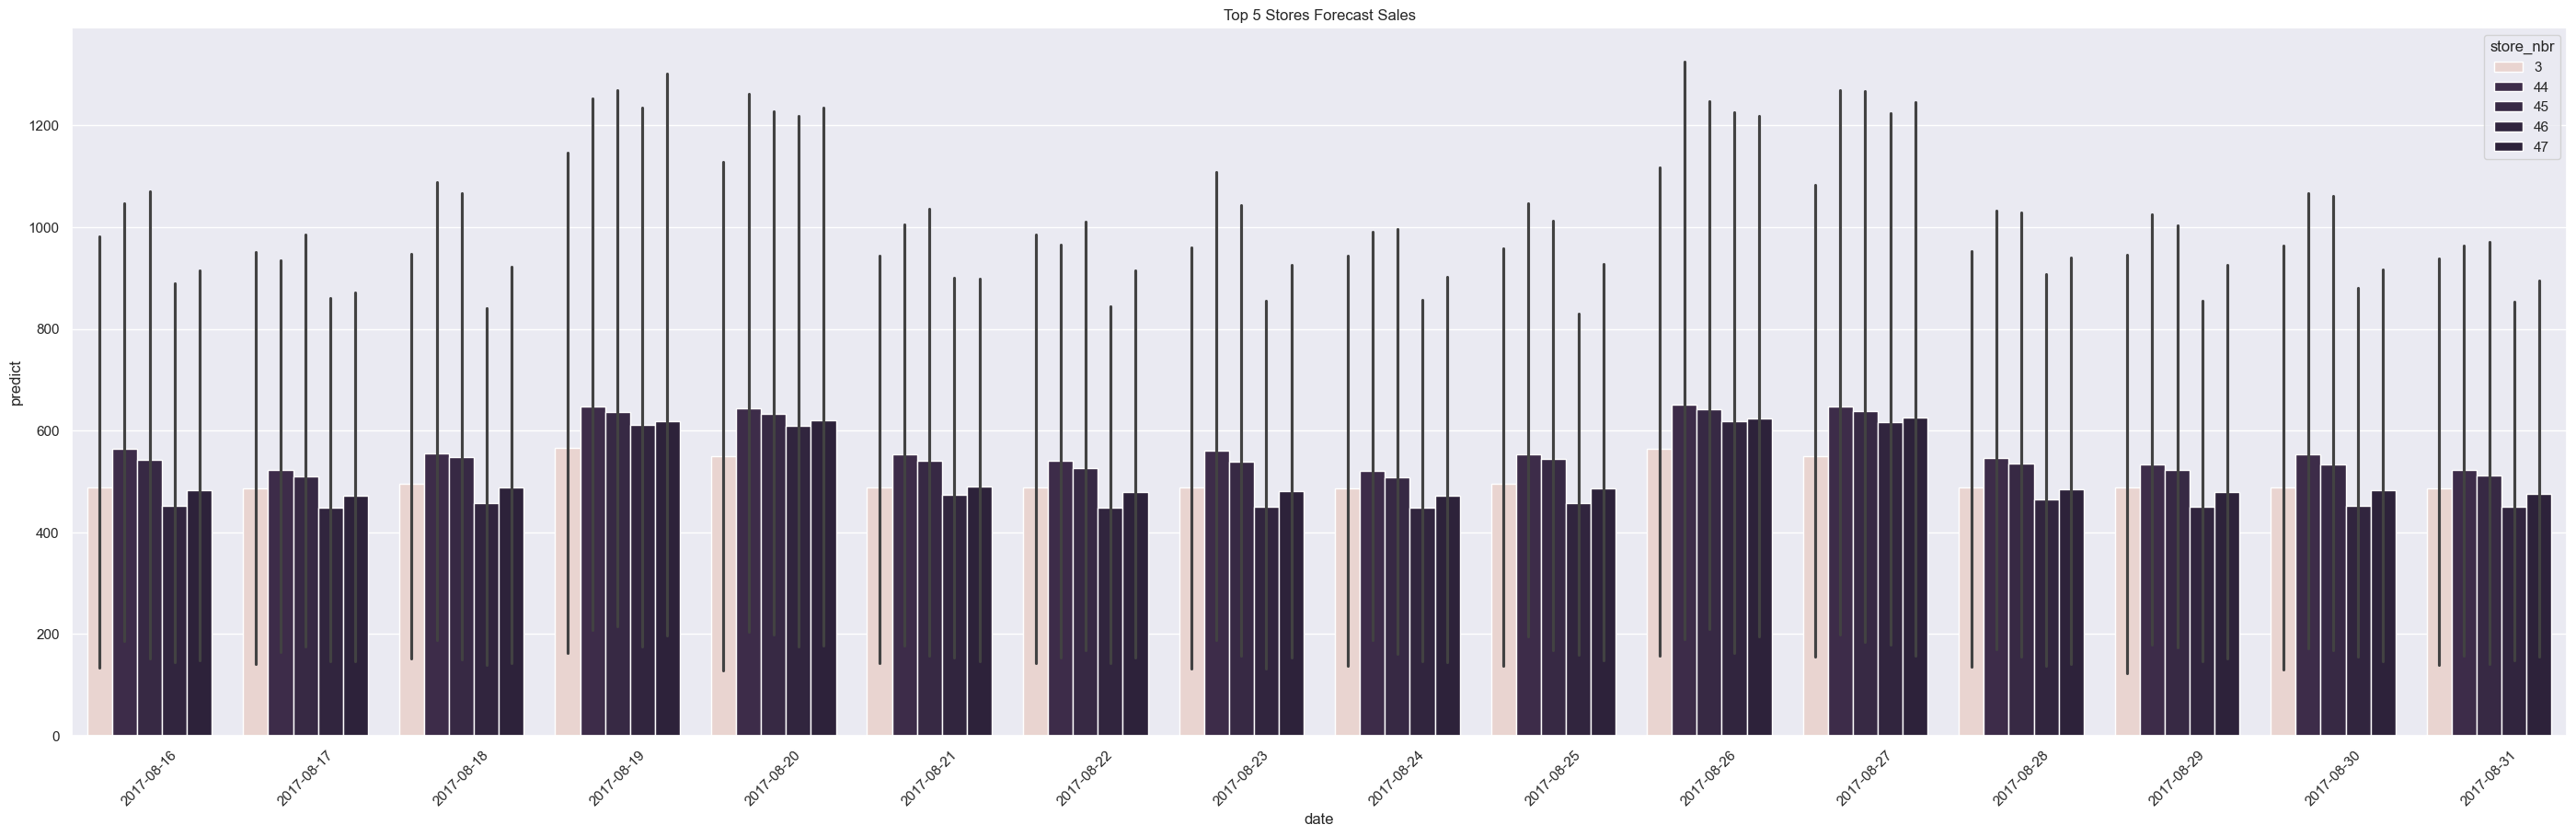

In [77]:
# Top 5 Stores Forecast Sales
mean_by_store = testset_pred.groupby('store_nbr')['predict'].sum()

# select only the top 5 in 'store_nbr'
top_5_stores = mean_by_store.nlargest(5).index
top_5_store_data = testset_pred[testset_pred['store_nbr'].isin(top_5_stores)]
#top_5_store_data['store_nbr'] = top_5_store_data['store_nbr'].astype('category')

sns.barplot(data=top_5_store_data, x='date', y='predict', hue='store_nbr').set_title('Top 5 Stores Forecast Sales')
sns.set(rc={"figure.figsize":(28, 10)}) 
plt.xticks(rotation=45)
plt.show()

# References

https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

https://www.geeksforgeeks.org/random-forest-regression-in-python/

#### Saving the model

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pickle

# Load example data
data = load_iris()
X = data.data
y = data.target

# Create and train the model
model = RandomForestClassifier()
model.fit(X, y)

# Save the trained model
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

